# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xboxили PlayStation). 

**Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.**

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

**Описание данных**

- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы долларов)
- `EU_sales` — продажи в Европе (миллионы долларов)
- `JP_sales` — продажи в Японии (миллионы долларов)
- `Other_sales` — продажи в других странах (миллионы долларов)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board).

## 1. Общая информация

In [64]:
# подключим необходимые библиотеки и настройки графики

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st


sns.set_palette(palette='Set1')
%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None  # default='warn'

In [65]:
# прочитаем датасет из файла и запишем в датафрейм df

df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [66]:
# посмотрим первые 5 строк датафрейма

df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Сразу заметны неверные типы данных:
- в столбце `Year_of_Release` нужно заменить тип на `int` – дробных значений года не бывает;
- в столбце `User_Score` дробные числа, но некоторые значения целочисленные – тип данных нужно заменить на `float`.


Посмотрим, какие типы данных вообще есть в таблице.

In [67]:
# выведем общую информацию о датафрейме

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Остальные типы данных в порядке, но количество строк различается – есть пропущенные значения. 

Названия столбцов для удобства можно привести к нижнему регистру.

In [68]:
# проверим на наличие явных дубликатов

df.duplicated().sum()

0

Явных дубликатов не обнаружено.

In [69]:
# посчитаем количество пропущенных значений в столбцах

df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

По 2 пропущеных значения в `Name` и `Genre`, 269 в `Year_of_Release` \
и по несколько тысяч в столбцах `Critic_Score`, `User_Score` и `Rating`.

### Вывод по 1 шагу:

Мы рассмотрели полученные данные – это таблица на 16715 строк. 

Следующие шаги:
- Привести к нижнему регистру названия столбцов таблицы
- Поменять типы данных у столбцов `Year of Release` и `User_Score` 
- Разобраться с пустыми значениями в столбцах

Можно приступать к подготовке и очистке данных.

## 2. Подготовка данных

### Заменим названия столбцов (приведем к нижнему регистру):

In [70]:
# приведем названия столбцов к нижнему регистру и проверим результат

df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Преобразуем данные в нужные типы:

Из всей таблицы только один столбец имел ошибочно неверный тип данных – год релиза не может быть дробным, поэтому приводим в целочисленный.

In [71]:
# поменяем тип данных в столбце year_of_release 

df['year_of_release'] = df['year_of_release'].astype('Int64')
df['year_of_release'].dtype

Int64Dtype()

### Обработаем пропуски:

В прошлом шаге мы обнаружили 2 пропущеных значения в `name` и `genre`, 269 в `year_of_release` и по несколько тысяч в столбцах `critic_score`, `user_score` и `rating`.

#### Обработка столбцов `name` и `genre`

In [72]:
# посмотрим на пустые значенияя по столбцу name

df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [73]:
# посмотрим на пустые значенияя по столбцу genre

df[df['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Видим, что это записи с одинаковыми индексами. 

Вероятно, данные по этой игре отсутствуют из-за технической неполадки (нет названия игры, но есть оценка – скорее всего какая-то ошибка в названии, например, написание иероглифами некорректно обработалось при выгрузке).

Похоже, что из этих данных никакой пользы получить нельзя – слишком много пропущенных параметров и не от чего оттолкнуться для их заполнения. 

**Решение: оставим эти строки без изменений – их количество несущественно, такое количество потерь не повлияет на результаты анализа.**

#### Обработка столбца `year_of_release`

In [74]:
# посмотрим на пустые значения по столбцу year_of_release

df[df['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,<NA>,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,<NA>,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,<NA>,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,<NA>,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


**Решение: некоторые значения здесь можно извлечь из `name` (там присутствует год), а другие можно попытаться взять из аналогичной игры для других платформ.**

In [75]:
# посмотрим пример пустого значения у одной из игр

df.query('name == "Madden NFL 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,Madden NFL 2004,XB,2003,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,Madden NFL 2004,GC,2003,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


Предположим, что игры для разных платформ выпускались в один и тот же год. 

**Решение: можно заполнить пропуски данными по году выпуска, которые есть для других платформ соответствующей игры.**

Заполним эти значения перебором в цикле:

In [76]:
# напишем цикл для заполнения года релиза на основе других платформ по имени игры

for i in df[df['year_of_release'].isnull() == True].index:  
    df['year_of_release'][i] = df.loc[df['name'] == df['name'][i], \
                                      'year_of_release'].max()

In [77]:
# посчитаем пропуски в столбце year_of_release после замены

df['year_of_release'].isna().sum()

146

Пропусков стало меньше, но небольшое количество осталось – оно явно меньше 10% всей базы, поэтому не повлияет на результат исследования.

**Решение: оставим пропуски без изменений.**

#### Обработка столбцов `critic_score`, `user_score` и `rating`

In [78]:
# посмотрим на пустые значенияя по столбцу critic_score

df[df['critic_score'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN


In [79]:
# посмотрим на пустые значенияя по столбцу user_score

df[df['user_score'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN


In [80]:
# посмотрим на пустые значенияя по столбцу rating

df[df['rating'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN


Количество пропущенных данных слишком велико (более 10% базы), но не поддается заполнению с помощью стандартных методов (медианы, соседние значения).

Похоже, что пропуски здесь не случайны и вызваны тем, что по данным играм не велись наблюдения и не подсчитывался рейтинг.

**Решение: оставим пропуски как есть – заменять их нечем.**

Однако, обратим внимание на аббревиатуру `tbd` в столбцах с оценкой пользователей:

In [81]:
# посмотрим выдачу с оценкой пользователей tbd

df.query('user_score == "tbd"').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,<NA>,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E


Это сокращение от `To Be Determined`, что можно расшифровать как "оценки пока не существует" (например, из-за того, что количество голосов слишком мало, чтобы посчитать их среднее). 

Значит, это не ошибка и значения пропущены нарочно, оценки просто нет. 

**Решение: заменим значения на неизвестные – `NaN`:**

In [82]:
# заменим значения tbd на Nan методом replace

df['user_score'] = df['user_score'].replace('tbd', np.nan, regex=True)

In [83]:
# заменим тип данных в столбце user_score 

df['user_score'] = df['user_score'].astype('float')
df['user_score'].dtype

dtype('float64')

Можно попробовать «предсказать» оценку пользователей, исходя из оценки критиков, если коэффициент корреляции между ними достаточно высок. Рассчитаем корреляции:

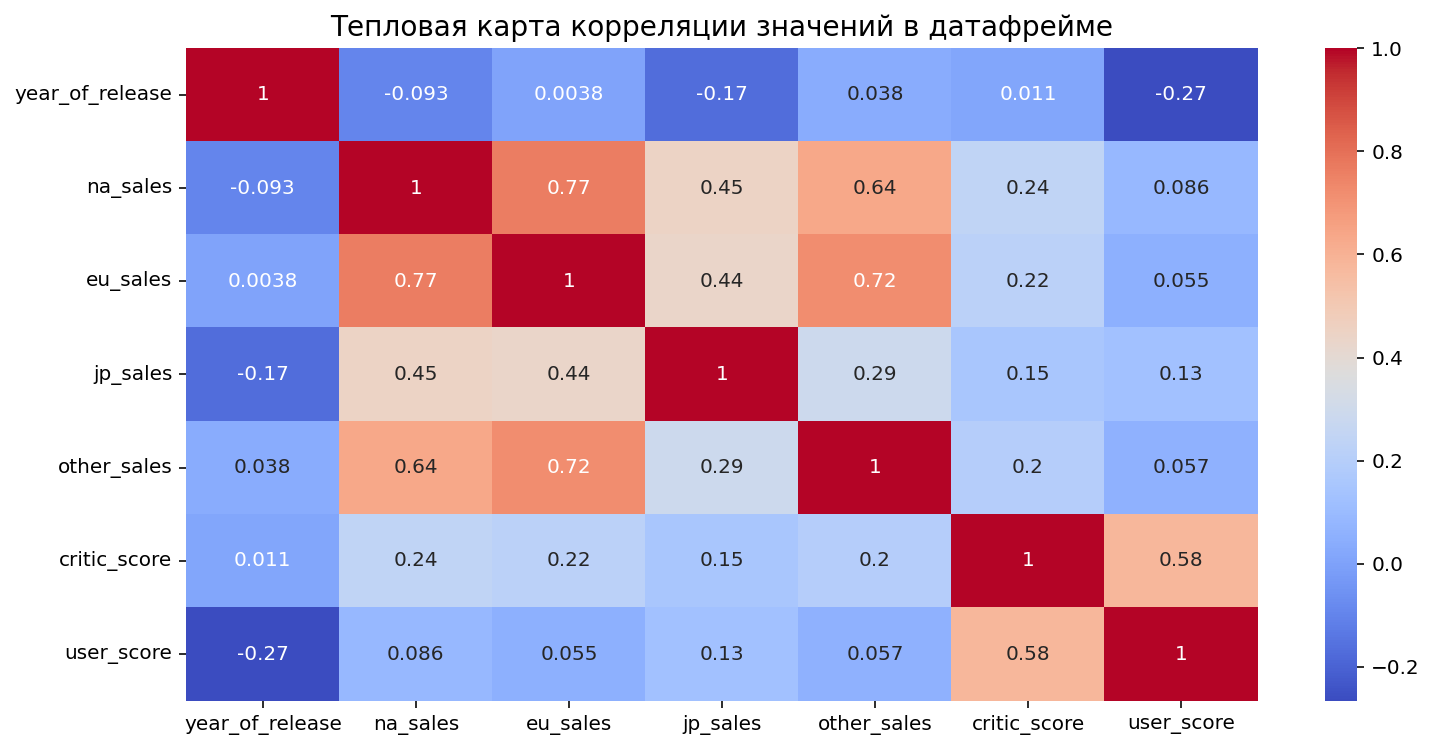

In [84]:
# построим тепловую карту корреляций в датафрейме

plt.figure(figsize=(12,6))
plt.title('Тепловая карта корреляции значений в датафрейме', fontsize=14)


sns.heatmap(df.corr(), annot=True, cmap='coolwarm');

In [85]:
print('Коэффициент корреляции Пирсона:', df['critic_score'].corr(df['user_score']).round(2))

Коэффициент корреляции Пирсона: 0.58


Коэффициент хоть и высок, но недостаточно близок к 1, чтобы заменить пропуски наверняка. 

**Решение: оставим как есть, не будем пытаться подставить значения.**


Для анализа нам также понадобится столбец `rating` со всеми входящими в него значениями, поэтому `NaN` в нем для удобства заменим на строку `unknown`:

In [86]:
# заменим значения Nan в столбце rating методом replace

df['rating'] = df['rating'].fillna('unknown')

### Добавление столбца с суммой продаж

In [87]:
# добавим в датафрейм новый столбец total_sales с суммой продаж

df['total_sales'] = df['na_sales'] + df['eu_sales'] \
    + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


### Вывод по 2 шагу:

Мы обработали данные:
- Привели столбцы к подходящим типам данных
- Привели названия столбцов к нижнему регистру
- Обработали пропуски: заменили возможные варианты и оставили значения, которые невозможно заменить с помощью расчетов
- Проверили корреляцию между оценками критиков и пользователей – она недостаточно сильна, чтобы заполнить пропуски
- Добавили новый столбец с суммой всех продаж во всех регионах

Можно приступать к исследовательскому анализу данных.

## 3. Исследовательский анализ данных

Напомним цель исследования: **выявить определяющие успешность игры закономерности.**

Выполним действия по шагам, чтобы прийти к заключению.


#### 1. Посмотрим, сколько игр выпускалось в разные годы. 

Важны ли данные за все периоды?

In [88]:
# сгруппируем данные по году выпуска игры и количеству выпущенных игр

games_by_year = df \
    .groupby(['year_of_release']) \
    .agg({'name' : 'count'}) \
    .rename(columns=({'name' : 'total_games'}))

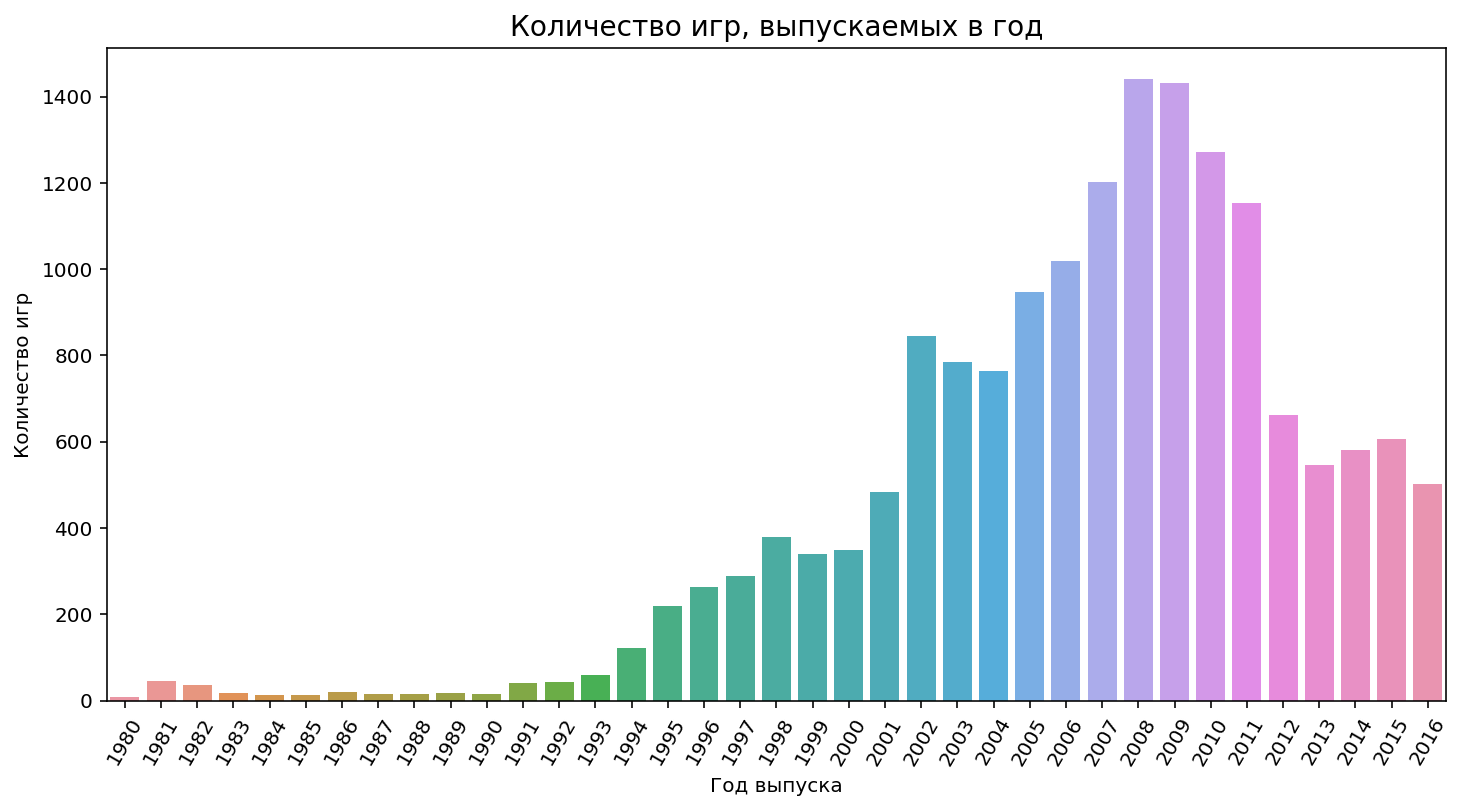

In [89]:
# построим график для визуализации выборки

plt.figure(figsize=(12,6))

sns.barplot(x=games_by_year.index, y=games_by_year['total_games']);
plt.title('Количество игр, выпускаемых в год', fontsize=14);
plt.xlabel('Год выпуска');
plt.xticks(rotation=60);
plt.ylabel('Количество игр');

- В таблице и на графике хорошо заметно, как количество выпусков игр начиная с середины 90х годов стало расти. Предполагается, что это связано с тем, что персональные компьютеры в то время стали более доступны и распространены, что стимулировало рост популярности игр и повысило их коммерческую выгоду для издателей

>`Цитата из Википедии: "1990-е годы были ознаменованы заметными инновациями в компьютерных играх. Основными достижениями называют переход от растровой графики к полностью полигональному 3D, снижение популярности аркадных игр и появление нескольких новых жанров - шутер от первого лица, стратегия в реальном времени и MMO."`

- Примерно с 2010 года наблюдается снижение количества выпускаемых игр. Предполагается, что это связано с популяризацией мобильных устройств (не рассматриваются в данном датасете)

>`Цитата с сайта hype.tech: "2008 год. Развитие мобильных видеоигр было подстегнуто появлением двух крупнейших магазинов App Store и Google Play."`

 - В датасете имеются данные за 36 лет, но для нашего анализа такой большой период не значим. 
 
**Для планирования продаж актуален период за последние 5 лет, тем более что на графике виден сильный спад с 2012 года, что означает, что многие платформы перестали быть актуальными**

2. Посмотрим, как менялись продажи по платформам. 

Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. 

За какой характерный срок появляются новые и исчезают старые платформы?


In [90]:
# посчитаем средний срок продаж игр

platform_lifecycle = df \
    .groupby(['platform']) \
    .agg({'year_of_release' : 'nunique'}) \
    .sort_values('year_of_release', ascending=False) \
    .reset_index()

In [91]:
# посмотрим на статистики по выборке

platform_lifecycle.describe()

,year_of_release
count,31.000000
mean,7.806452
std,5.114811
min,1.000000
25%,4.000000
50%,7.000000
75%,11.000000
max,26.000000


Медианный срок продаж игр каждой платформы составляет **7 лет** – это и есть характерный срок, в которые появляются и исчезают платформы. 

In [92]:
# выведем на экран топ-10 платформ-долгожителей

platform_lifecycle.query('year_of_release > 7').head(10)

,platform,year_of_release
0,PC,26
1,GB,13
2,NES,12
3,X360,12
4,PSP,12
5,PS3,12
6,PS2,12
7,2600,11
8,Wii,11
9,DS,11


Видим, что PC является самой старой платформой – продажи игр для ПК до сих пор активны.

Исходя из медианного срока жизни платформы и задач проекта, будем анализировать данные за последние 5 лет как наиболее актуальные.

In [93]:
# создадим новый датафрейм с выборкой за последние 5 лет включительно

df_5y = df[df['year_of_release'] > 2011]
df_5y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2899 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2899 non-null   object 
 1   platform         2899 non-null   object 
 2   year_of_release  2899 non-null   Int64  
 3   genre            2899 non-null   object 
 4   na_sales         2899 non-null   float64
 5   eu_sales         2899 non-null   float64
 6   jp_sales         2899 non-null   float64
 7   other_sales      2899 non-null   float64
 8   critic_score     1322 non-null   float64
 9   user_score       1540 non-null   float64
 10  rating           2899 non-null   object 
 11  total_sales      2899 non-null   float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 297.3+ KB


In [94]:
# создадим функцию, возвращающую группировку по платформе, продажам и году выпуска игр

def platform_total_sales_yearly(name):
    selection = df_5y[(df_5y['platform'] == name)]
    total = selection.groupby(['year_of_release']).agg({'total_sales' : 'sum'})
    return total

In [95]:
# сгруппируем данные по названию платформы и количеству продаж суммарно

sales_by_platform = df_5y \
    .groupby(['platform']) \
    .agg({'total_sales' : 'sum'}) \
    .rename(columns=({'total_sales' : 'total_sales'})) \
    .sort_values('total_sales', ascending=False) \
    .reset_index()

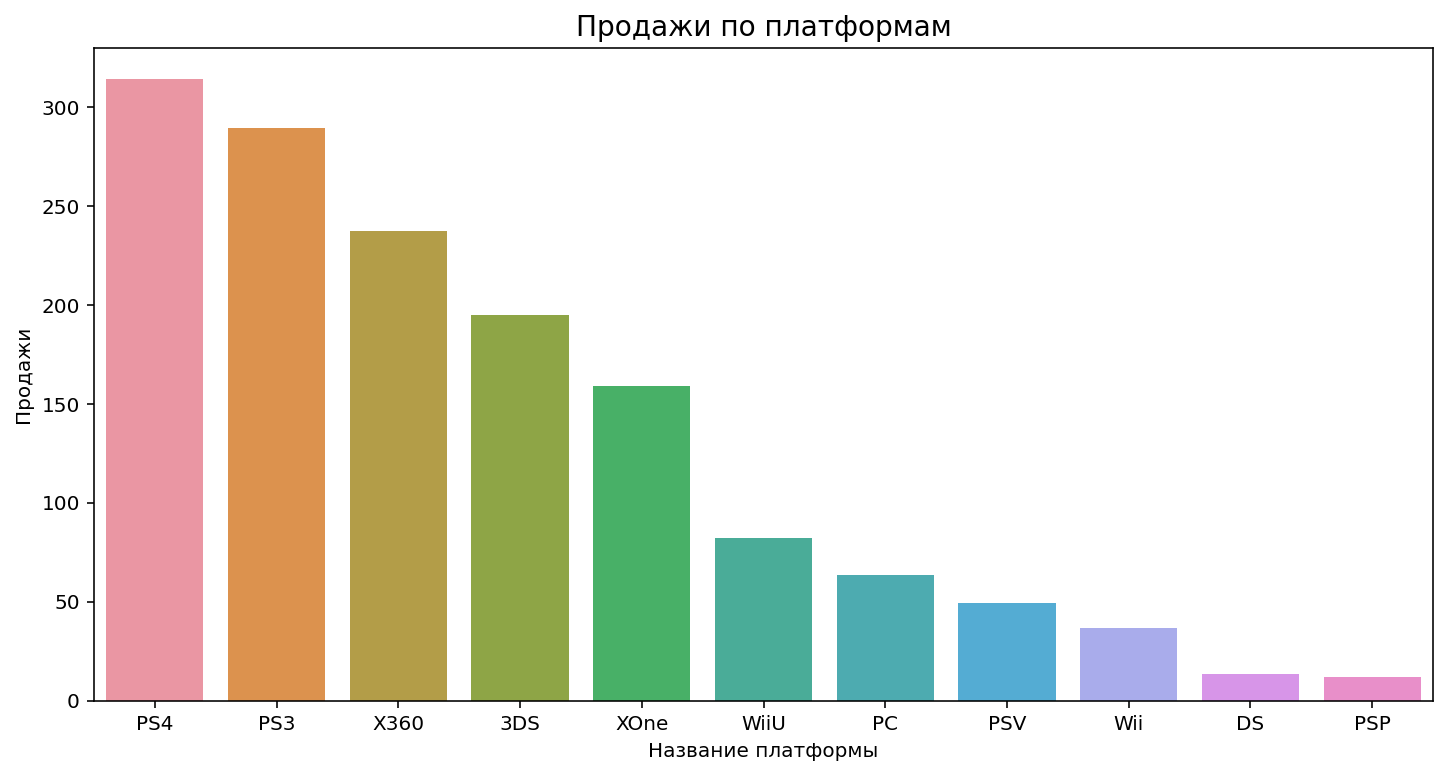

In [96]:
# построим график для визуализации выборки

plt.figure(figsize=(12,6))

sns.barplot(x=sales_by_platform['platform'],y=sales_by_platform['total_sales']);
plt.title('Продажи по платформам', fontsize=14);
plt.xlabel('Название платформы');
plt.ylabel('Продажи');

In [97]:
# построим выборку по суммарных продажам для топ-5
top5_platforms = sales_by_platform.head(5)
top5_platforms

,platform,total_sales
0,PS4,314.14
1,PS3,289.71
2,X360,237.52
3,3DS,195.01
4,XOne,159.32


Пятерка лидеров по суммарным продажам за последние 5 лет – это платформы PS4, PS3, X360, 3DS, XOne.

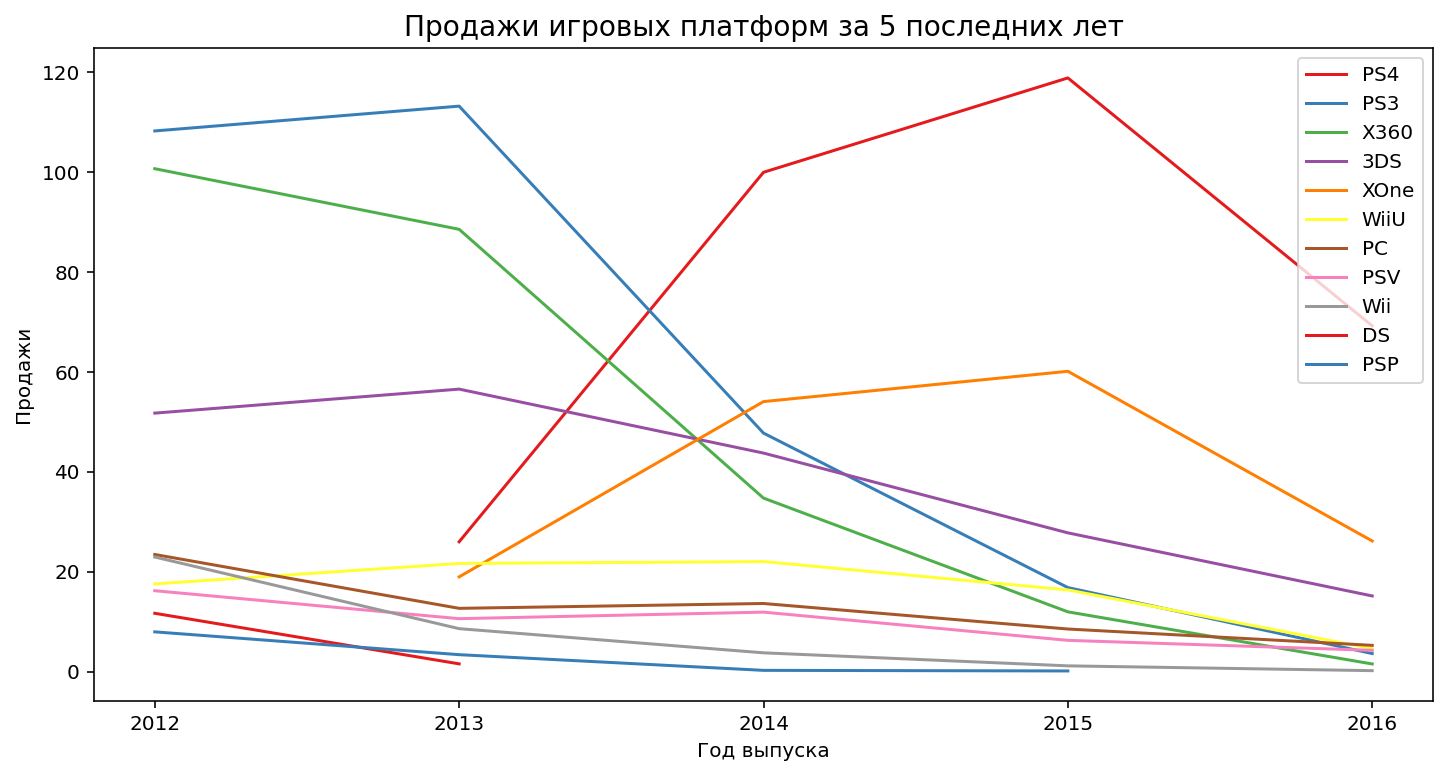

In [98]:
# построим график для визуализации жизненных циклов платформ

plt.figure(figsize=(12,6))

for platform in list(sales_by_platform['platform']):
    sns.lineplot(data=platform_total_sales_yearly(platform) \
                 ['total_sales'], label=platform)

plt.title('Продажи игровых платформ за 5 последних лет', fontsize=14);
plt.xlabel('Год выпуска');
plt.ylabel('Продажи');
plt.xticks(range(2012, 2017));

Вывод:

- Медианный жизненный цикл платформы (от момента старта до окончания продаж) — 7 лет
- Срок, за который мы решили взять данные для дальнейшего анализа – 5 лет. Он наиболее актуален для маркетинговых задач
- Пятерка лидеров по суммарным продажам – PS4, PS3, X360, 3DS, XOne. Четыре из пяти платформ – это стационарные игровые приставки, и одна – мобильная (портативная)
- Популярные в более раннем приоде PS3 и X360 начали одновременное падение в 2013 и сошли на минимум к 2016. Можно сказать, что это уже не актуальные платформы, не рекомендуются как источник продаж
- Портативная игровая платформа 3DS занимает 4 место в ТОП-5, но с 2013 начинает терять объемы продаж. Вероятно, это связано с появлением конкурентов – смартфонов, которые становятся с каждым годом всё мощнее и могут посоревноваться в производительности и удобстве. Игры на эту платформу всё ещё могут быть актуальны, но не станут крупным источником объемов продаж. Учитывая медиану жизненного цикла, в ближайшее время есть риск, что платформа выйдет из оборота
- Другие портативные платформы показывают низкие продажи или вовсе прекратили выпуск игр (DS, PSP). Причина указана выше – распространенность мощных смартфонов. Не рекомендуется как источник объемов продаж
- В 2013 году появились 2 новые платформы – PS4 и XOne. Судя по графику, сейчас они являются лидерами продаж. Учитывая медианный срок жизни, игры для этих двух платформ будут оставаться актуальными еще несколько лет. Поэтому можно рекомендовать их как главный источник объемов продаж
- Платформа PC всё ещё остается актуальной, хоть и не входит в ТОП-5 за последние 5 лет. Возможно, низкие продажи связаны с распространенным "пиратством" игр на ПК, что снижает количество легальных покупок. Несмотря на это, ПК стоит на первом месте в топе платформ-долгожителей и может рекомендоваться как дополнительный источник продаж


5. Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишем результат.


In [99]:
# сохраним данные по топ-5 платформ за последние 5 лет в новый датафрейм

top5_platforms_list = ['PS4', 'PS3', 'X360', '3DS', 'XOne']
top5_5y = df_5y[df_5y['platform'].isin(top5_platforms_list)].reset_index()

top5_5y.head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
3,33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,14.60
4,34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


Рассчитаем границы статистически значимой выборки до выбросов и обновим датафрейм, чтобы получить более чистый результат:

In [100]:
# посмотрим описательные статистики, чтобы узнать диапазон разброса значений, медиану и средние

top5_5y['total_sales'].describe()

count    1824.000000
mean        0.655537
std         1.476061
min         0.010000
25%         0.060000
50%         0.190000
75%         0.630000
max        21.050000
Name: total_sales, dtype: float64

In [101]:
# создадим фильтр по межквартильному размаху
Q1 = top5_5y['total_sales'].quantile(0.25)
Q3 = top5_5y['total_sales'].quantile(0.75)
IQR = Q3 - Q1

# создадим новый датафрейм с очищенными от выбросов данными по топ-5 платформ за всё время
top5_5y_filtered = top5_5y.query('(@Q1 - 1.5 * @IQR) \
    <= total_sales <= (@Q3 + 1.5 * @IQR)')

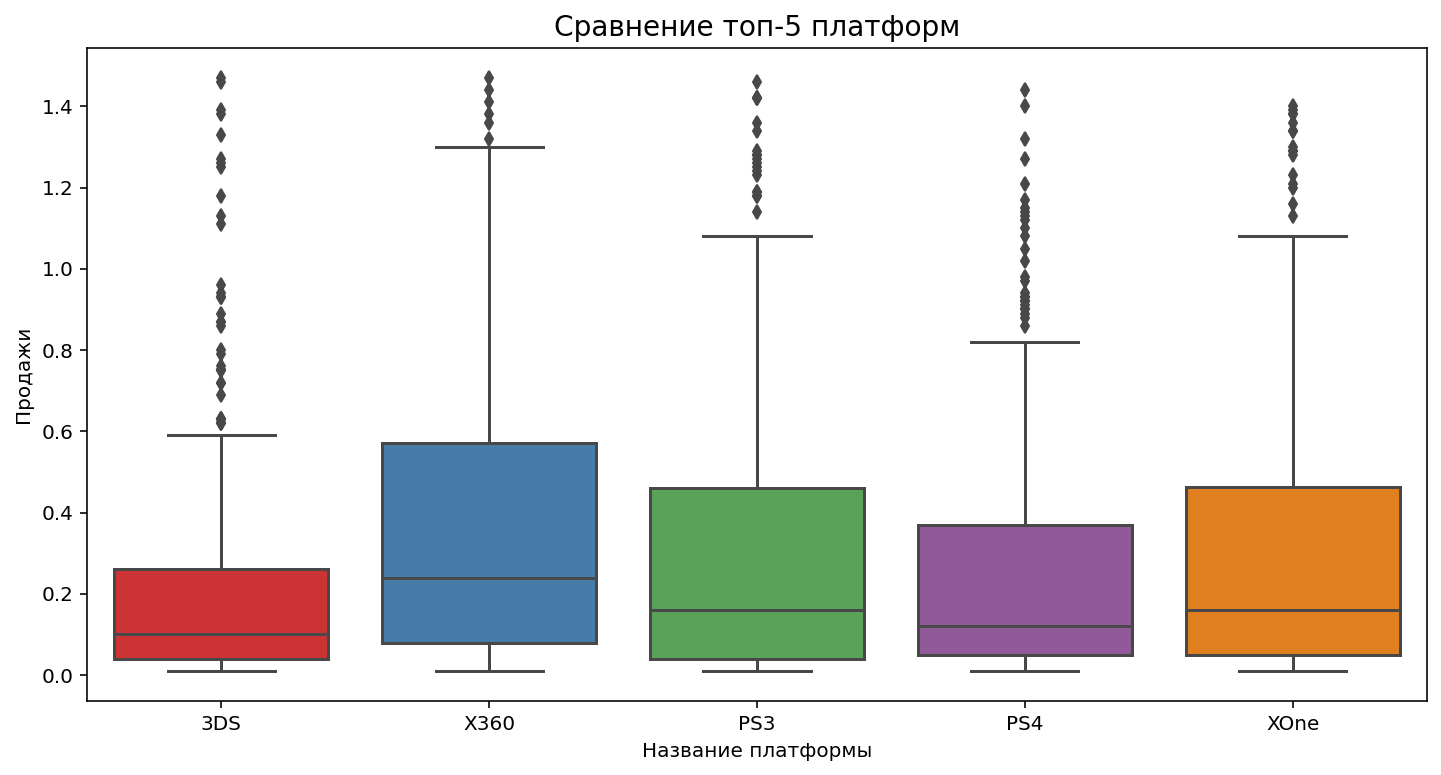

In [102]:
# построим диаграммы размаха по каждой платформе топ-5

plt.figure(figsize=(12,6))

sns.boxplot(data=top5_5y_filtered, x='platform', y='total_sales')
plt.title('Сравнение топ-5 платформ', fontsize=14);
plt.xlabel('Название платформы');
plt.ylabel('Продажи');

In [103]:
# выведем таблицу статистик со средними продажами по топ-5 платформ

top5_5y \
    .groupby('platform')['total_sales'] \
    .describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,397.0,0.491209,1.385416,0.01,0.04,0.11,0.320,14.60
PS3,494.0,0.586457,1.461448,0.01,0.05,0.20,0.610,21.05
PS4,392.0,0.801378,1.609456,0.01,0.06,0.20,0.730,14.63
X360,294.0,0.807891,1.706880,0.01,0.10,0.31,0.870,16.27
XOne,247.0,0.645020,1.036139,0.01,0.06,0.22,0.685,7.39


Вывод: 

- На диаграммах размаха мы видим распределение продаж по 5 популярным платформам
- Самая высокая среди конкурентов медиана у X360, также показатели продаж у этой платформы сильно разбросаны (большой межквартильный размах и широкие границы типичных значений). Предположительно, игры для этой платформы продаются стабильно, без особых всплесков 
- Продажи игр на платформы PS3 и XOne схожи между собой как по медиане, так и по размаху. Похоже, что игры для этих платформ продаются примерно одинаково стабильно
- Самый узкий размах и маленькая медиана у платформы 3DS – в основном продажи для этой платформы вырьируются не сильно и протекают на довольно низких уровнях. Но при этом платформа имеет самый большой разброс по выбросам в верхнем диапазоне. Похоже, что продажи игр на эту платформу нельзя назвать стабильными, но рынок встречает появление новых игр для нее с неким ажиотажем
- У платформы PS4 обнаружены средние показатели по всем параметрам: медиана, максимум, разброс. Большое количество выбросов в верхнем диапазоне может говорить о том, что продажи игр для этой платформы идут "волнами", во время которых можно получить хорошую прибыль

6. Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Сформулируем выводы.


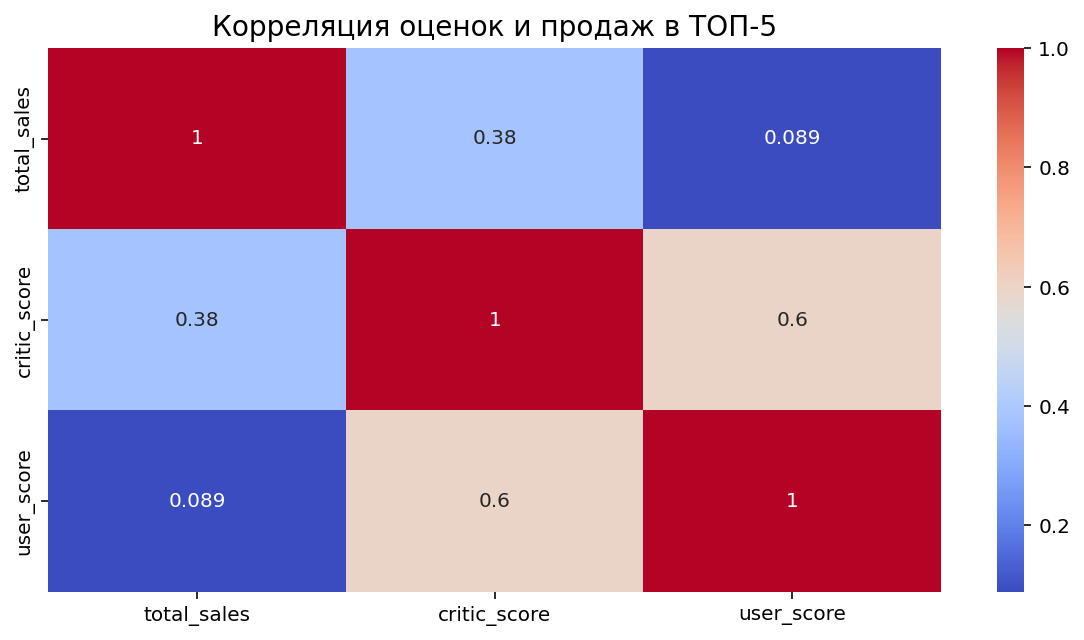

In [104]:
# рассмотрим общую корреляцию оценок и продаж в датафрейме за последние 5 лет

plt.figure(figsize=(10,5))
plt.title('Корреляция оценок и продаж в ТОП-5', fontsize=14)


sns.heatmap(top5_5y_filtered[['total_sales', 'critic_score', 'user_score']] \
            .corr(), annot=True, cmap='coolwarm');

В среднем по выборке видим, что оценки пользователей практически не связаны с продажами, связь слабая. 

Оценки критиков имеют чуть большую корреляцию с продажами, связь можно назвать умеренной.

Рассмотрим лидирующую платформу PS3 отдельно:

In [105]:
# выделим даные по платформе PS3 в отдельный датафрейм

ps3 = top5_5y_filtered[top5_5y_filtered['platform']=='PS3']

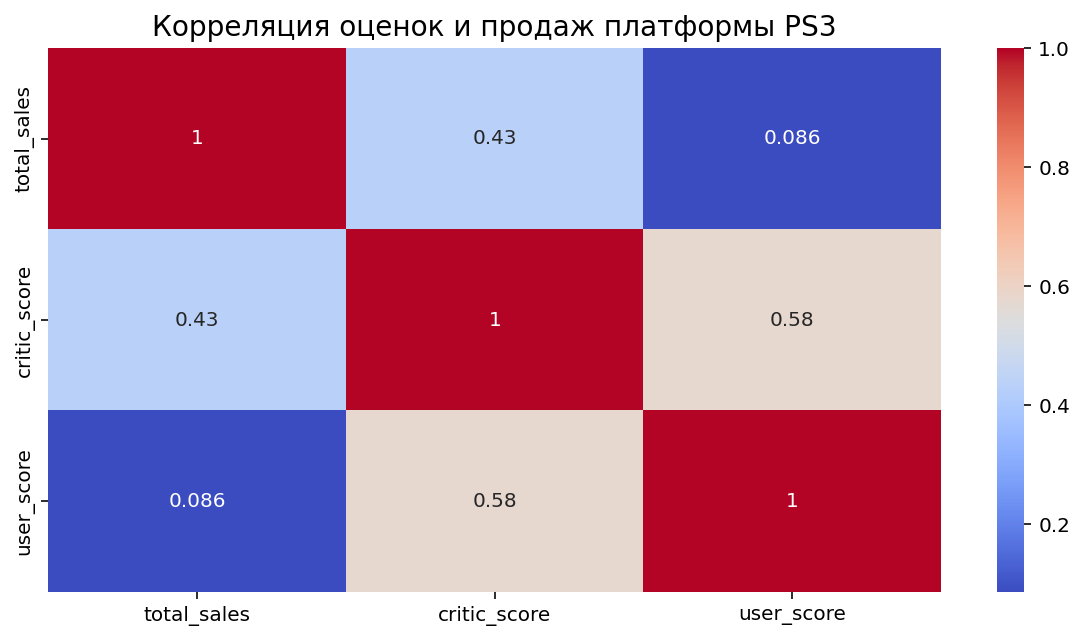

In [106]:
# рассмотрим корреляции отдельно по платформе PS3
plt.figure(figsize=(10,5))
plt.title('Корреляция оценок и продаж платформы PS3', fontsize=14)


sns.heatmap(ps3[['total_sales', 'critic_score', 'user_score']] \
            .corr(), annot=True, cmap='coolwarm');

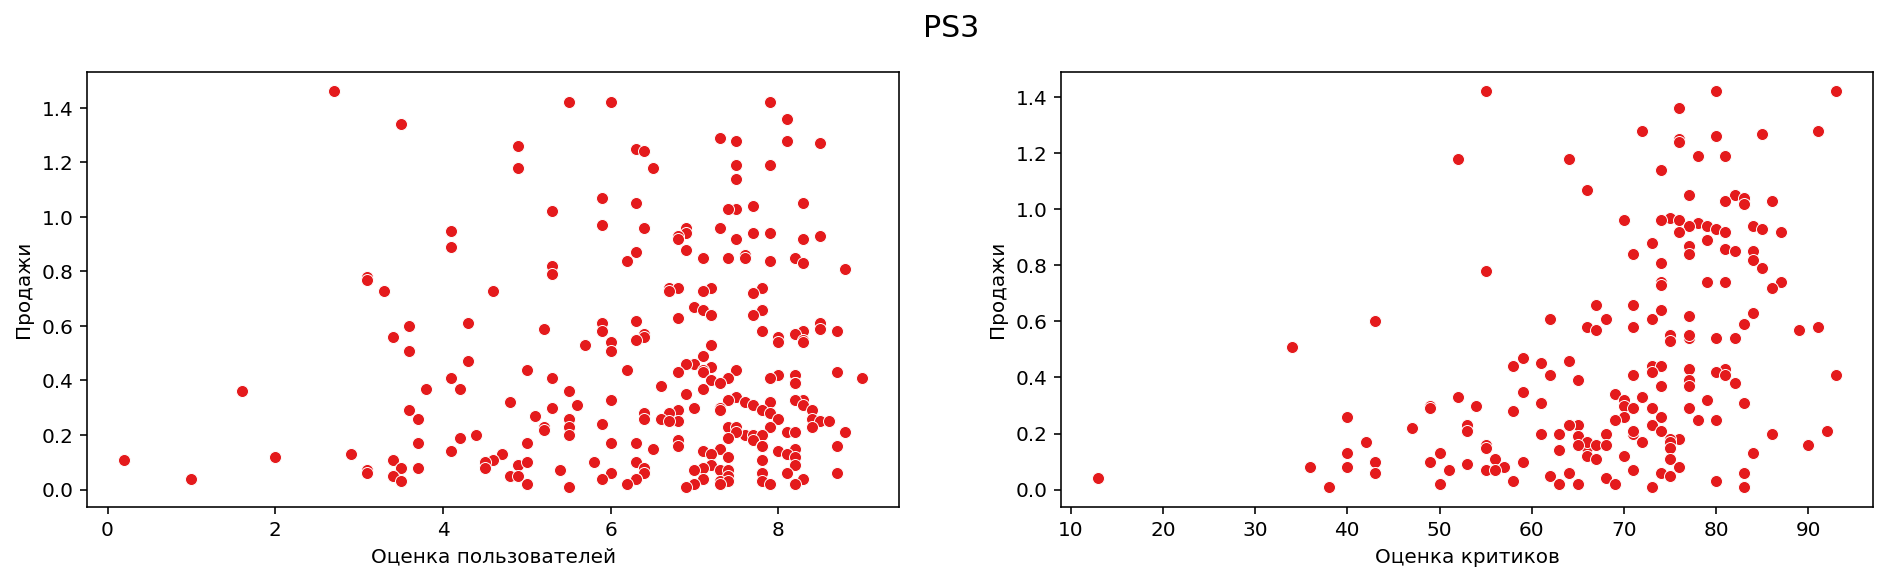

In [107]:
# построим диаграммы рассеивания для PS3 по продажам и оценке

fig, ax = plt.subplots(1 ,2, figsize=(16,4))
fig.suptitle('PS3', fontsize=15)
ax[0].set(xlabel='Оценка пользователей')
ax[1].set(xlabel='Оценка критиков')
ax[0].set(ylabel='Продажи')
ax[1].set(ylabel='Продажи')

sns.scatterplot(data=ps3, x='user_score', y='total_sales', ax=ax[0])
sns.scatterplot(data=ps3, x='critic_score', y='total_sales', ax=ax[1])

plt.show()

Видим, что корреляция не сильно отличается от средней по топ-4 платформ: очень слабая связь с оценками пользователей и умеренная – с оценками критиков.

Однако, относительно всей выборки корреляция продаж с мнением критиков у PS3 чуть более выражена (на +0.05 п.п. или +13%).

7. Соотнесем выводы с продажами игр на других платформах.

In [108]:
# напишем функцию, которая выведет графики и выводы для всех платформ из топ-5

def top5_sales_corr(platform_name):
    platform = top5_5y_filtered[top5_5y_filtered['platform']==platform_name]
    fig, ax = plt.subplots(1, 2, figsize=(16,4))
    sns.scatterplot(data=platform, x='user_score', y='total_sales', ax=ax[0])
    sns.scatterplot(data=platform, x='critic_score', y='total_sales', ax=ax[1])

    fig.suptitle(platform_name, fontsize=15)
    ax[0].set(xlabel='Оценка пользователей')
    ax[1].set(xlabel='Оценка критиков')
    ax[0].set(ylabel='Продажи')
    ax[1].set(ylabel='Продажи')
    plt.show()

    user_c = platform['total_sales'].corr(platform['user_score'])
    critic_c = platform['total_sales'].corr(platform['critic_score'])
                                            
    print('Корреляция оценки критиков с продажами:', critic_c.round(2))
    print('Корреляция оценки пользователей с продажами:', user_c.round(2))



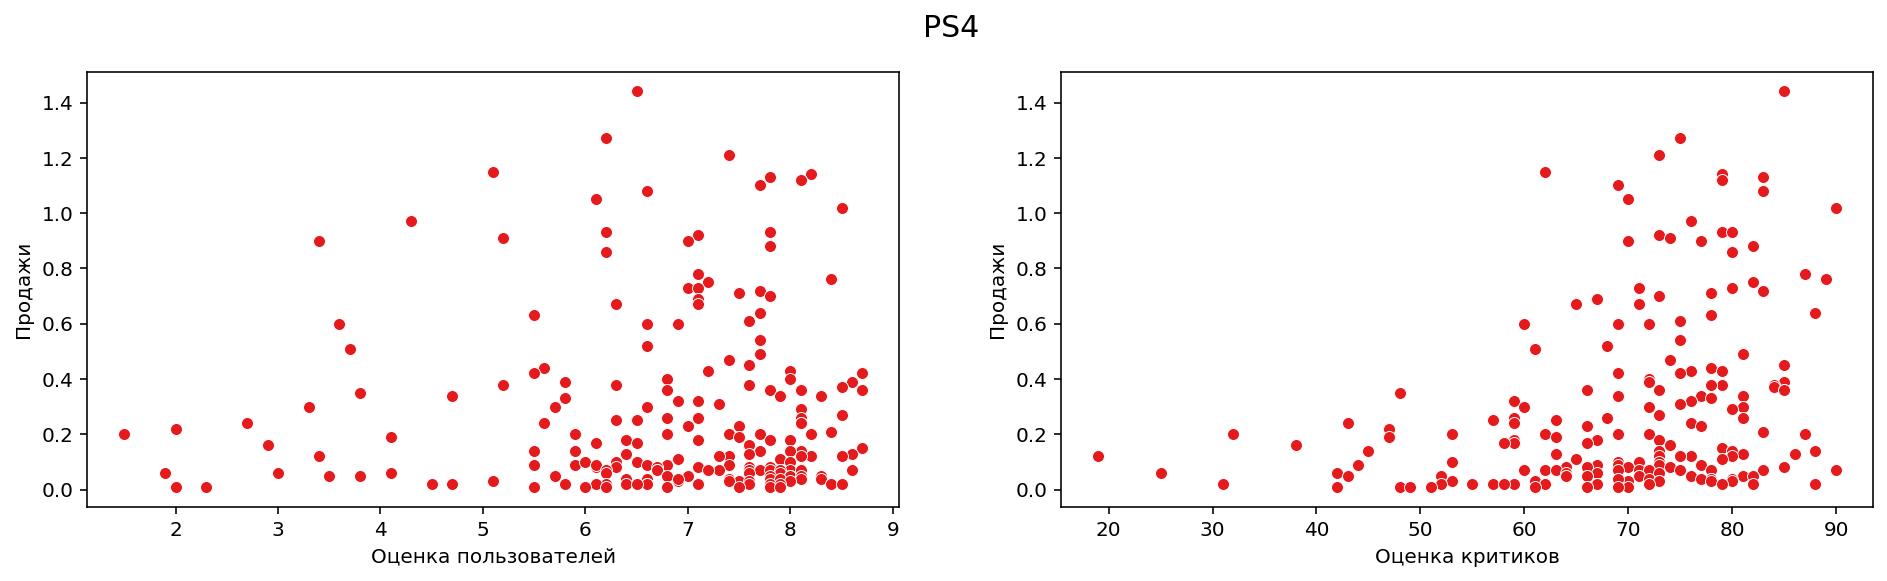

Корреляция оценки критиков с продажами: 0.32
Корреляция оценки пользователей с продажами: 0.02


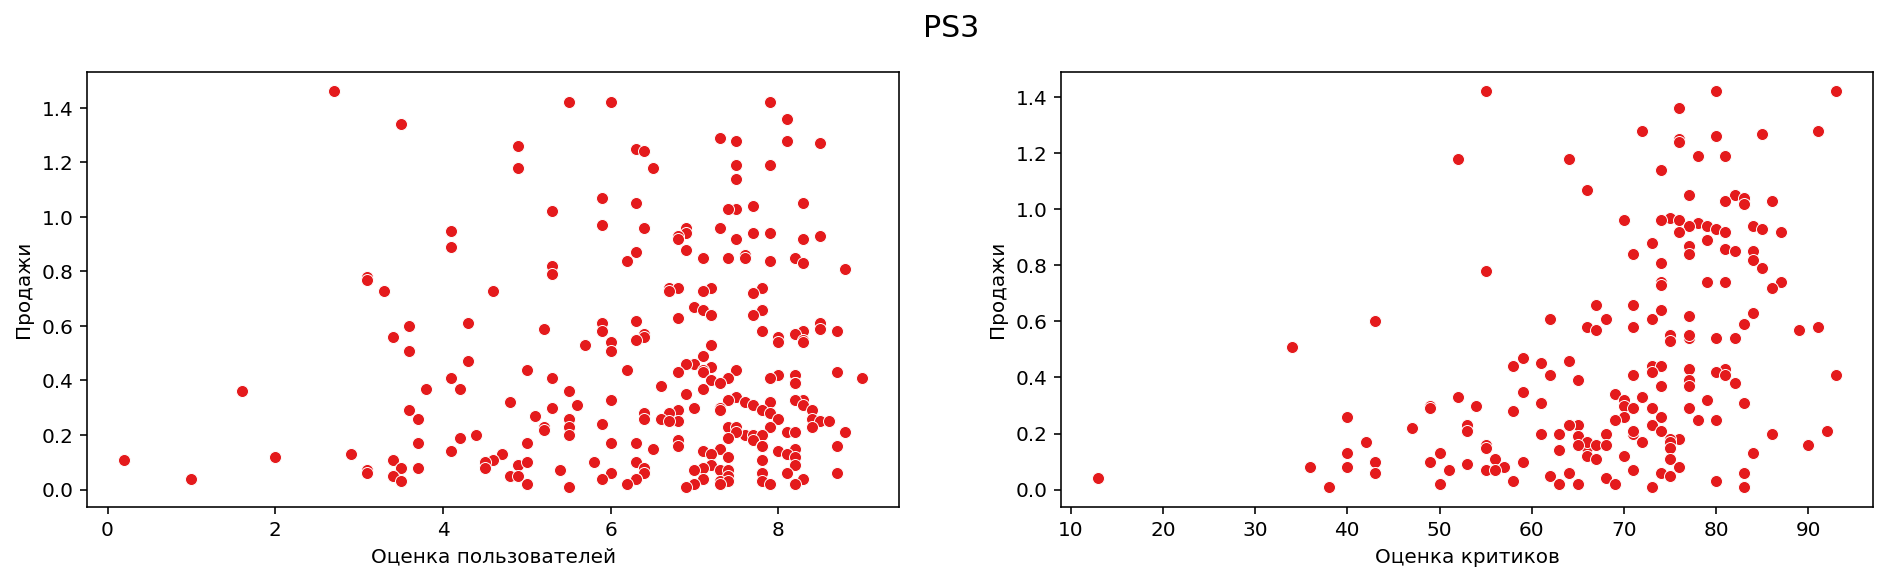

Корреляция оценки критиков с продажами: 0.43
Корреляция оценки пользователей с продажами: 0.09


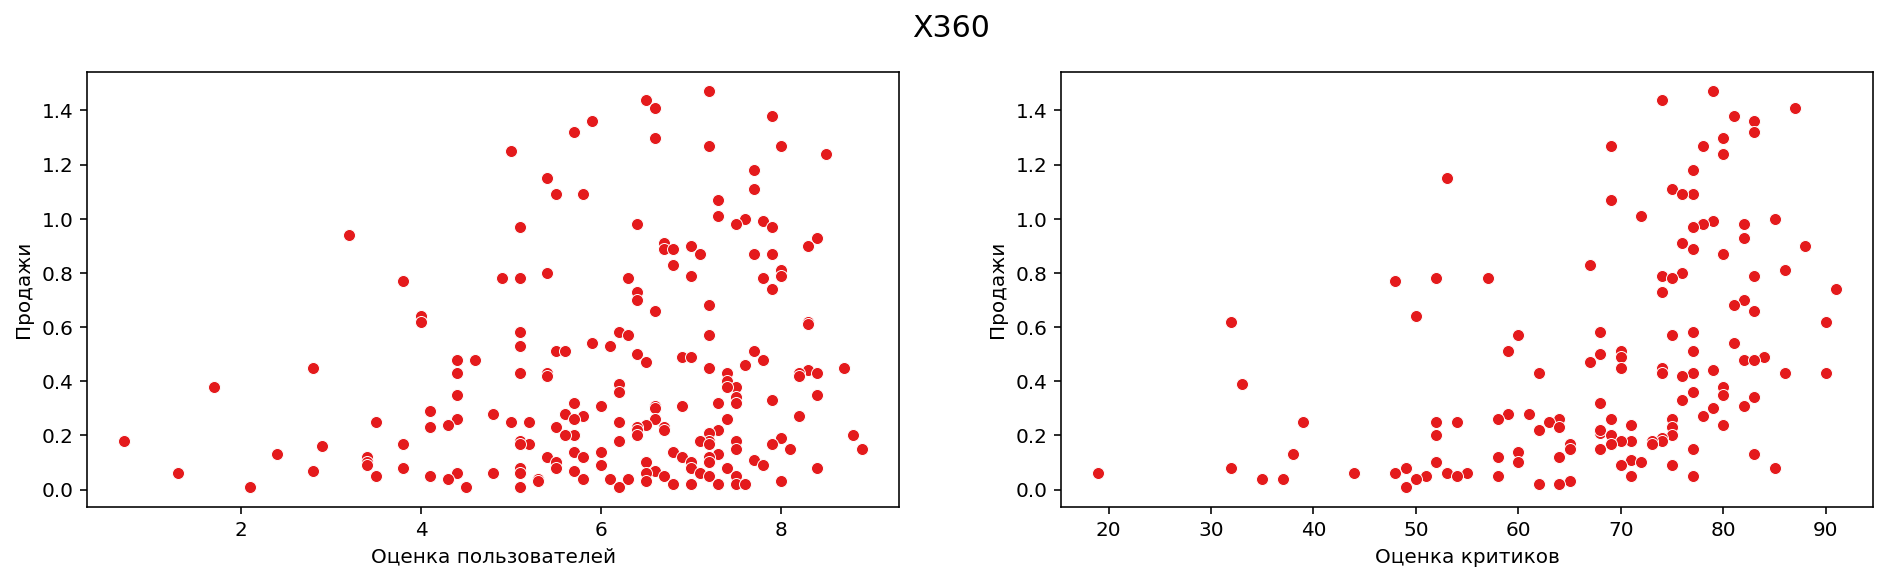

Корреляция оценки критиков с продажами: 0.45
Корреляция оценки пользователей с продажами: 0.21


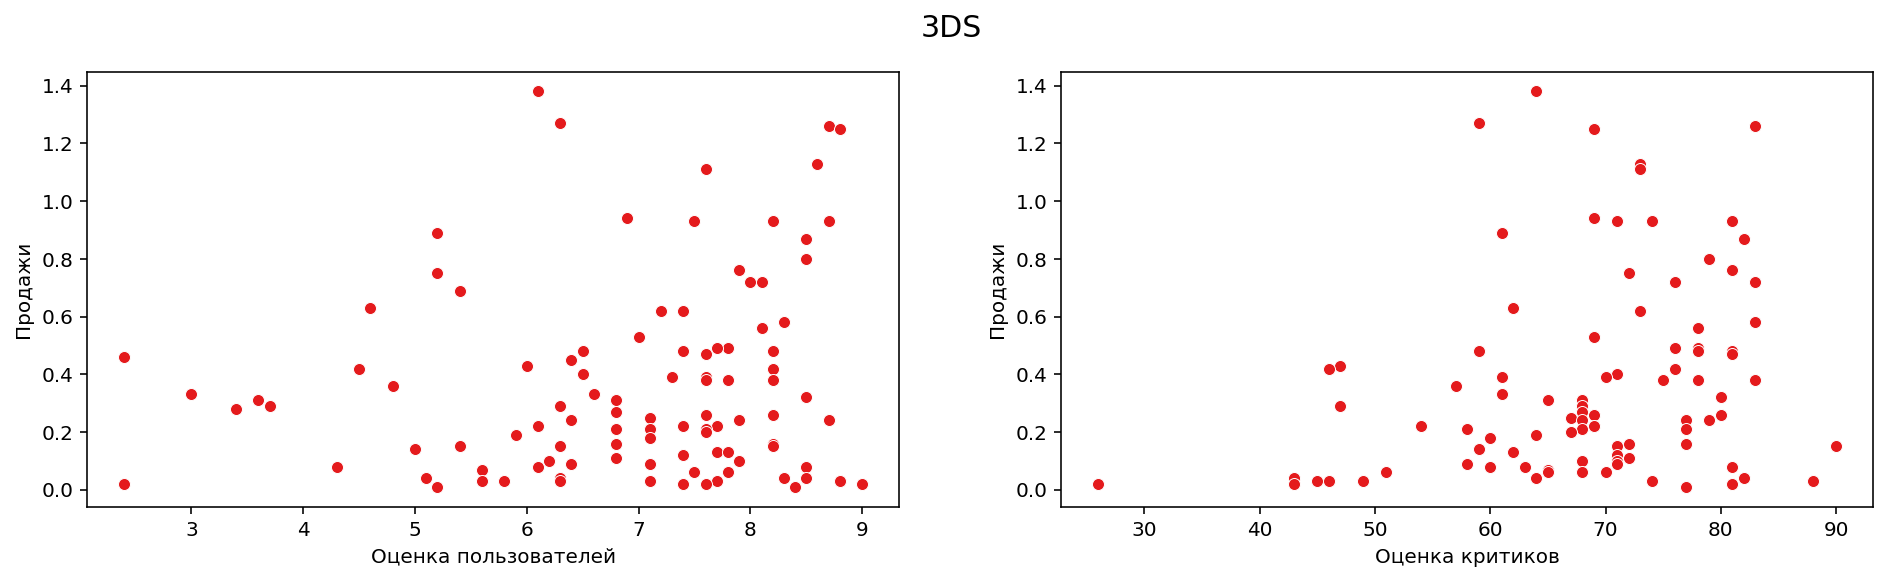

Корреляция оценки критиков с продажами: 0.25
Корреляция оценки пользователей с продажами: 0.14


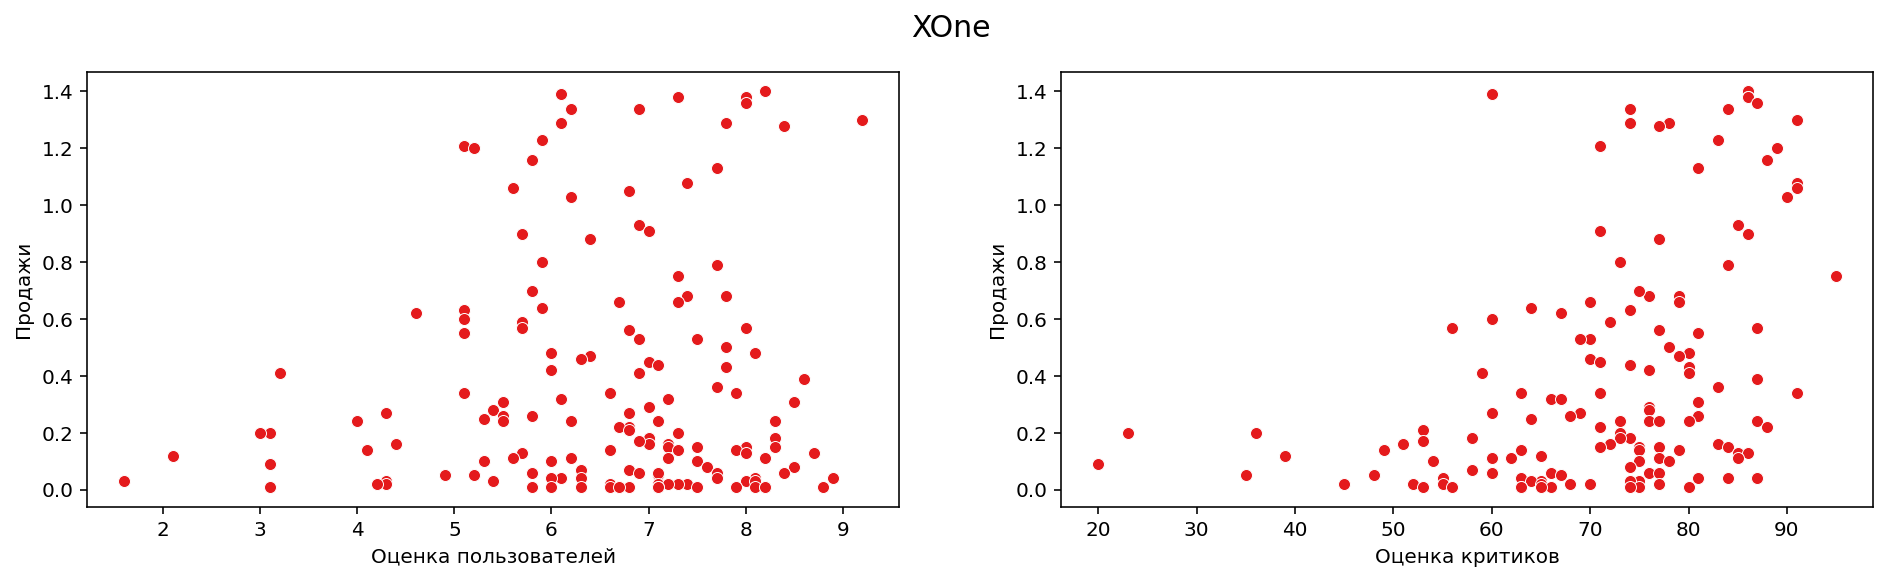

Корреляция оценки критиков с продажами: 0.42
Корреляция оценки пользователей с продажами: 0.08


In [109]:
# выведем диаграммы рассеивания с корреляцией оценок и продаж для топ-5 платформ

for platform in top5_platforms_list:
    top5_sales_corr(platform)

Вывод: 

- У платформ PS3, PS4 и XOne крайне слабая связь между оценкой пользователей и объемом продаж (< 0.1) 
- У платформы X360 связь продаж с оценками пользователей слабая, но приближается к умеренной (> 0.2)
- Умеренная, но тем не менее самая сильная из представленных, связь оценок критиков с продажами у платформ PS3, X360 и XOne (>0.42). Это можно использовать в продвижении, выбирая для рекламы игры с более высоким рейтингом критиков
- Продажи игр для платформы 3DS слабо коррелируют что с оценками критиков, что с оценками пользователей


8. Посмотрим на общее распределение игр по жанрам. 

Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?


In [110]:
# сгруппируем данные по жанру и медиане продаж

median_sales_by_genre = top5_5y_filtered \
    .groupby(['genre']) \
    .agg({'total_sales' : 'median'}) \
    .rename(columns=({'total_sales' : 'median_sales'})) \
    .sort_values('median_sales', ascending=False) \
    .reset_index()

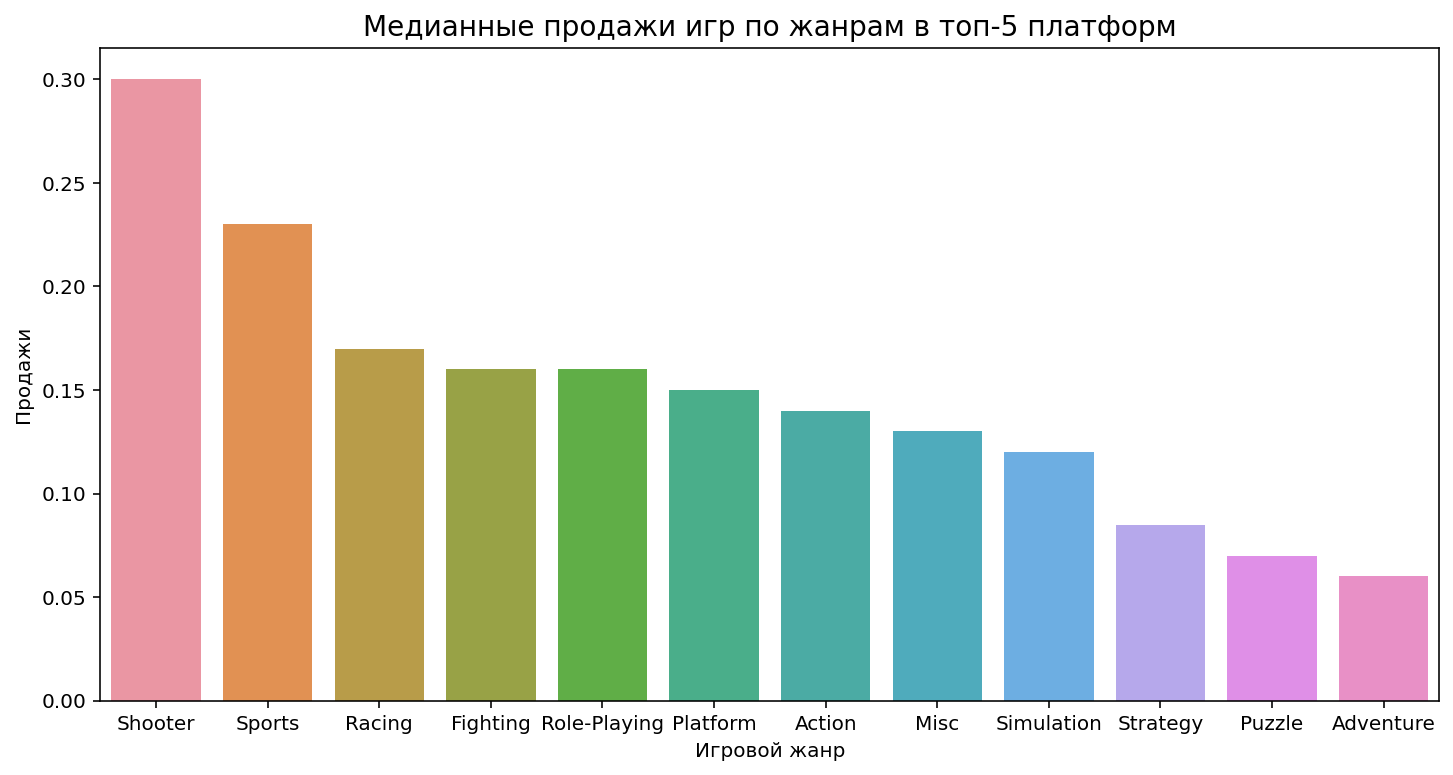

In [111]:
# построим график для визуализации выборки

plt.figure(figsize=(12,6))

sns.barplot(x=median_sales_by_genre['genre'], y=median_sales_by_genre['median_sales']);
plt.title('Медианные продажи игр по жанрам в топ-5 платформ', fontsize=14);
plt.xlabel('Игровой жанр');
plt.ylabel('Продажи');

Самым популярным является жанр Shooter, а самым непопулярным – Adventure.

In [112]:
# сгруппируем данные по жанру Shooter и медианному количеству продаж на платформах

shooter_by_platform = top5_5y_filtered[top5_5y_filtered['genre']=='Shooter'] \
    .groupby(['platform']) \
    .agg({'total_sales' : 'median'}) \
    .rename(columns=({'total_sales' : 'median_sales'})) \
    .sort_values('median_sales', ascending=False) \
    .reset_index()

shooter_by_platform

,platform,median_sales
0,XOne,0.490
1,PS3,0.330
2,X360,0.290
3,PS4,0.250
4,3DS,0.065


In [113]:
# сгруппируем данные по жанру Adventure и медианному количеству продаж на платформах

adventure_by_platform = top5_5y_filtered[top5_5y_filtered['genre']=='Adventure'] \
    .groupby(['platform']) \
    .agg({'total_sales' : 'median'}) \
    .rename(columns=({'total_sales' : 'median_sales'})) \
    .sort_values('median_sales', ascending=False) \
    .reset_index()

adventure_by_platform

,platform,median_sales
0,X360,0.075
1,PS4,0.070
2,3DS,0.060
3,XOne,0.060
4,PS3,0.050


Вывод: 
- самый популярный игровой жанр для топ-5 платформ за последние 5 лет – Shooter. Рекомендуется как первичный источник больших объемов продаж
- жанры Sports и Racing занимают 2 и 3 места в топе жанров соответственно, доли объема их продаж выглядят пригодными для получения прибыли
- платформа XOne – лидер по количеству медианных продаж самого популярного жанра Shooter с большим отрывом от конкурентов, на 2 месте PS3. Так как многие популярные игры портируются на более новые платформы, стоит ожидать, что продажи данного жанра на обновленной платформе PS4 будут тоже высокими
- самый непопулярный жанр для той же выборки – Adventure. Медианные продажи игр для разных платформ не сильно отличаются, однако первое место занимает X360. Не рекомендуется как источник активных продаж


## 4. Портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):

Самые популярные платформы (топ-5). Опишите различия в долях продаж.

In [114]:
# напишем функцию для расчета популярных платформ в регионах и построения графиков

region_list = ['na_sales', 'eu_sales', 'jp_sales']

def platform_rating(region_name):
    region_platform_sales = top5_5y_filtered \
        .groupby(['platform']) \
        .agg({region_name : 'sum'}) \
        .rename(columns=({region_name : 'total_sales'})) \
        .sort_values('total_sales', ascending=False) \
        .reset_index() \
        .head(5)

    name = region_name.split('_')
    plt.figure(figsize=(10,4))
    sns.barplot(x=region_platform_sales['platform'], 
                y=region_platform_sales['total_sales'])
    plt.title('Популярные платформы в регионе ' + name[0].upper(), fontsize=14)
    plt.xlabel('Название платформы')
    plt.ylabel('Продажи')
    plt.show();
    print('\n')


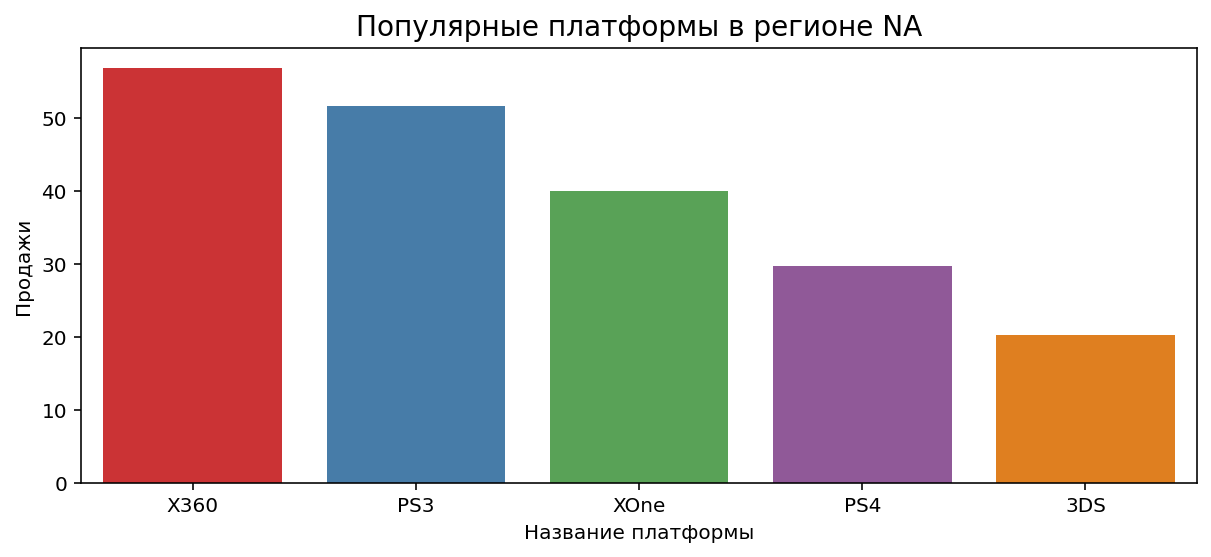

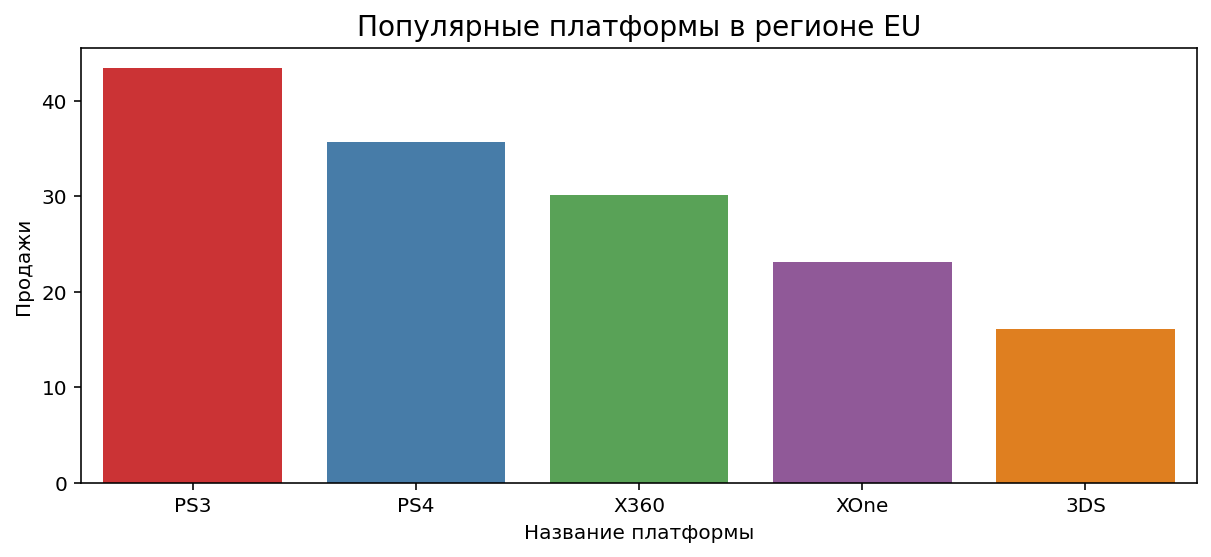

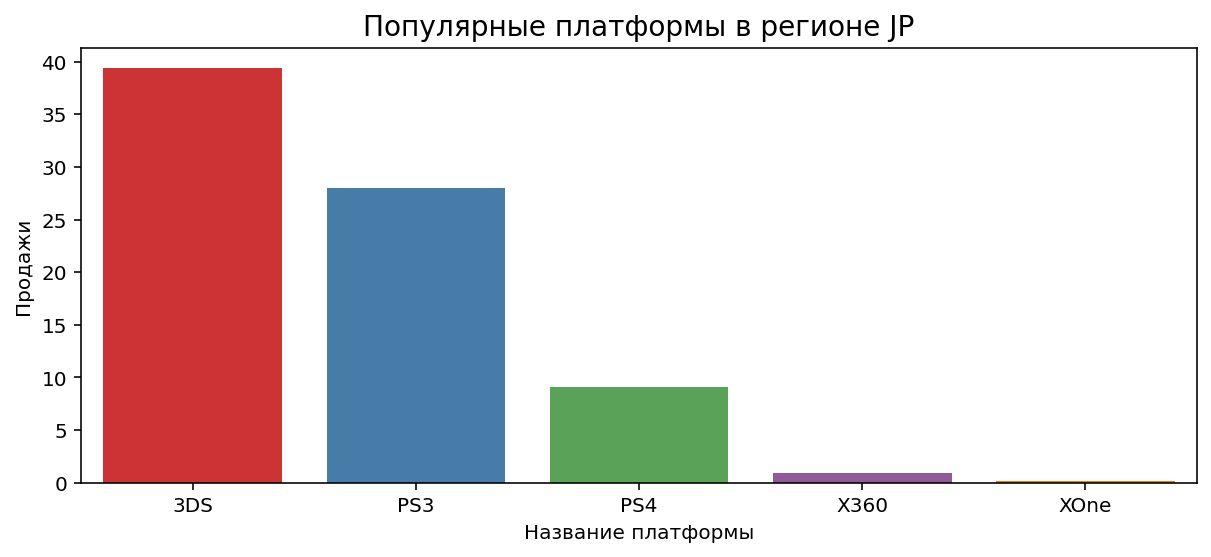

In [115]:
# выведем графики с топ-5 платформ для каждого региона

for region in region_list:
    platform_rating(region)

Вывод: 
- В Северной Америке самой популярной платформой является Xbox: на первом месте по объемам продаж X360. Так как уже вышла новая версия приставки данной серии, XOne, этот регион представляется наиболее выгодным для продажи игр на новую версию платформы. Сейчас продажи игр на XOne по этому региону занимают третье место и имеют все шансы через пару лет выйти на первое. Также большую долю занимают и продажи конкурентной платформы Playstation, тоже потенциально пригодные для продаж. Рекомендуется для продвижения обеих конкурирующих платформ в равной мере
- В Европе популярна платформа Playstation: PS3 занимает первое, а обновленная PS4 – уже второе место, поэтому рекомендуется в первую очередь для наращивания объемов продаж. Доля Xbox тоже большая, можно рекомендовать для продвижения
- В Японии популярна 3DS – мобильная платформа, которая находится на последнем месте в других странах. На рынке Японии, можно рекомендовать продажи игр под эту платформу. На втором месте по популярности приставки бренда Playstation – суммарно объемы продаж обеих версий можно приравнять к объемам лидера, рекомендовано к продвижению. Почти нет продаж игр на платформу Xbox – она не пользуется популярностью и не рекомендована для продвижения в данном регионе

Самые популярные жанры (топ-5). Пояснить разницу.

In [116]:
# напишем функцию для расчета популярных жанров в регионах и построения графиков

def genre_rating(region_name):
    region_genre_sales = top5_5y_filtered \
        .groupby(['genre']) \
        .agg({region_name : 'sum'}) \
        .rename(columns=({region_name : 'total_sales'})) \
        .sort_values('total_sales', ascending=False) \
        .reset_index() \
        .head(5)

    name = region_name.split('_')
    plt.figure(figsize=(10,4))
    sns.barplot(x=region_genre_sales['genre'], 
                y=region_genre_sales['total_sales'])
    plt.title('Популярные жанры в регионе ' + name[0].upper(), fontsize=14)
    plt.xlabel('Жанр')
    plt.ylabel('Продажи')
    plt.show();
    print('\n')

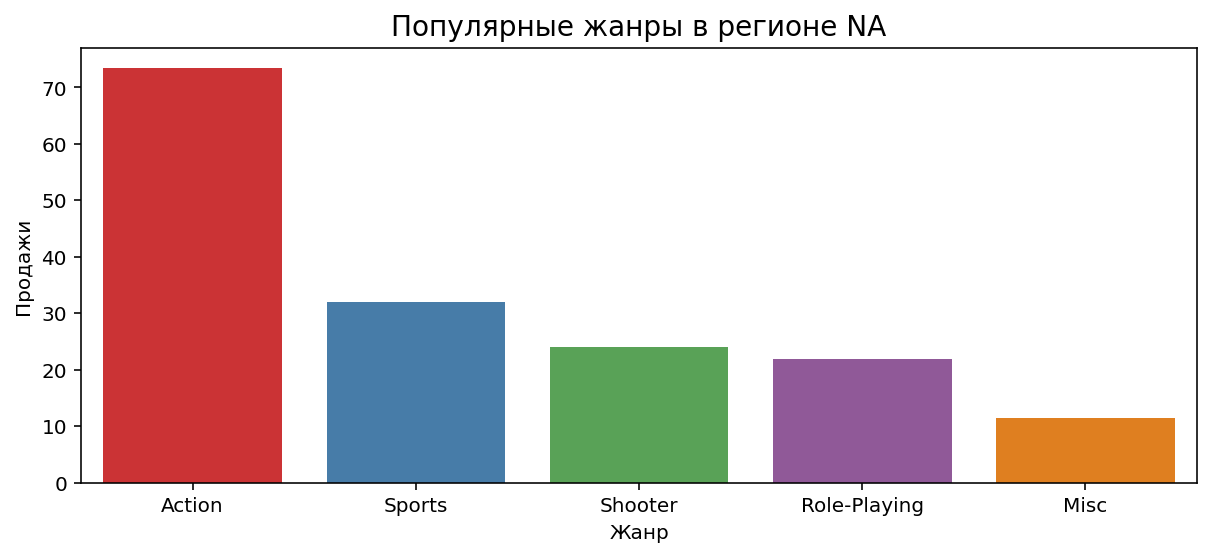

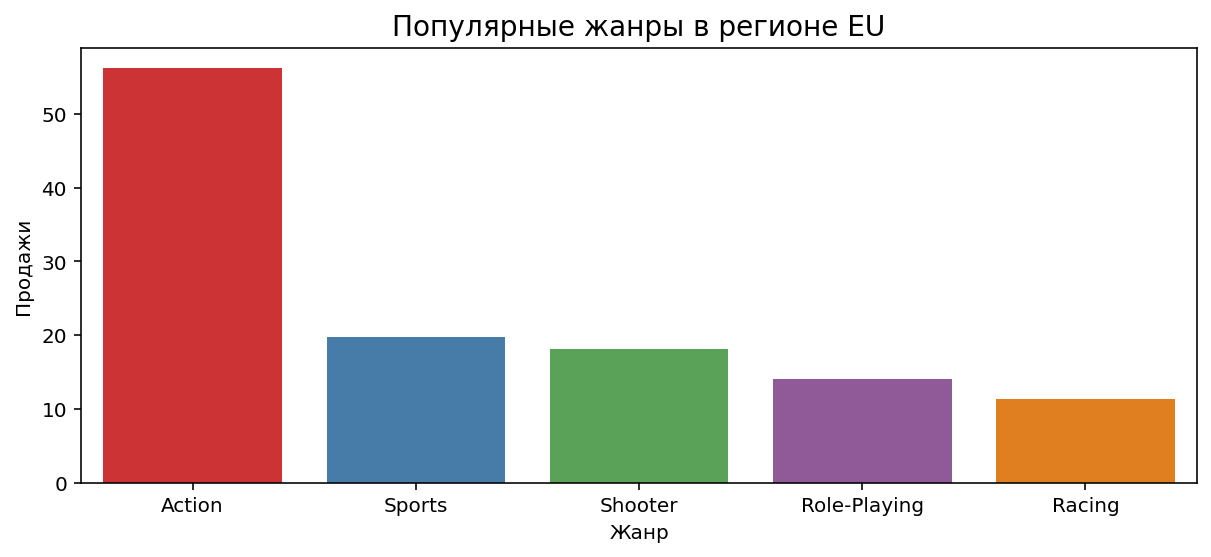

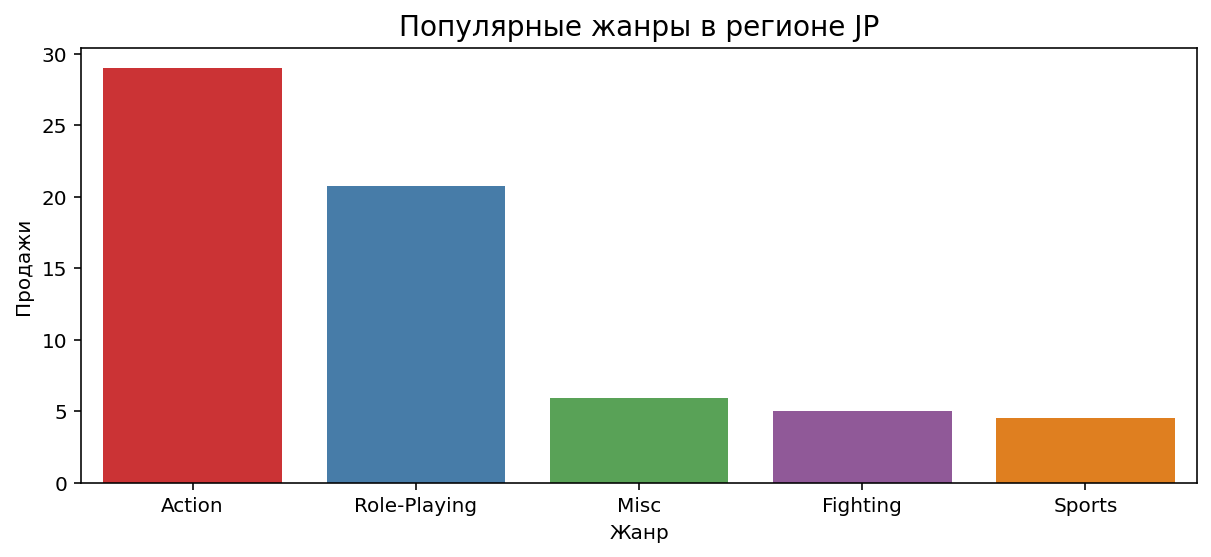

In [117]:
# выведем графики с топ-5 жанров для каждого региона

for region in region_list:
    genre_rating(region)

Вывод: 
- Во всех регионах не первом месте по продажам жанр Action – отличный вариант для получения стабильных прибылей от продаж
- Практически идентичная картина популярных жанров для Северной Америки и Европы: спортивные игры (Sports), шутеры (Shooter) и ролевые игры (Role-Playing) занимают 2, 3 и 4 места топа продаж соответственно
- В Японии основную массу продаж занимают Action и Role-Playing, другие жанры сильно отстают по объемам
- Особенности регионов: в Северной Америке в топ-5 входит жанр Misc, в Европе интересуются жанром Racing, а Японию отличает любовь к жанру Fighting

Влияет ли рейтинг ESRB на продажи в отдельном регионе?

**Описание оценок рейтинга ESBR:**

- **T («Teen»)** — «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.

- **M («Mature»)** — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории.

- **E («Everyone»)** — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. 

- **E10+ («Everyone 10 and older»)** — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать или немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови.




In [118]:
# напишем функцию для расчета популярных жанров в регионах NA, EU, JP и построения графиков

def esrb_sales_rating(region_name):
    esrb_sales = top5_5y_filtered \
        .groupby(['rating']) \
        .agg({region_name : 'sum'}) \
        .rename(columns=({region_name : 'total_sales'})) \
        .sort_values('total_sales', ascending=False) \
        .fillna('NaN') \
        .reset_index()
    
    name = region_name.split('_')
    plt.figure(figsize=(10,4))
    sns.barplot(x=esrb_sales['rating'], y=esrb_sales['total_sales'])
    plt.title('Объемы продаж игр по рейтингу ESBR в регионе ' \
              + name[0].upper(), fontsize=14)
    plt.xlabel('Рейтинг')
    plt.ylabel('Продажи')
    plt.show();
    print('\n')

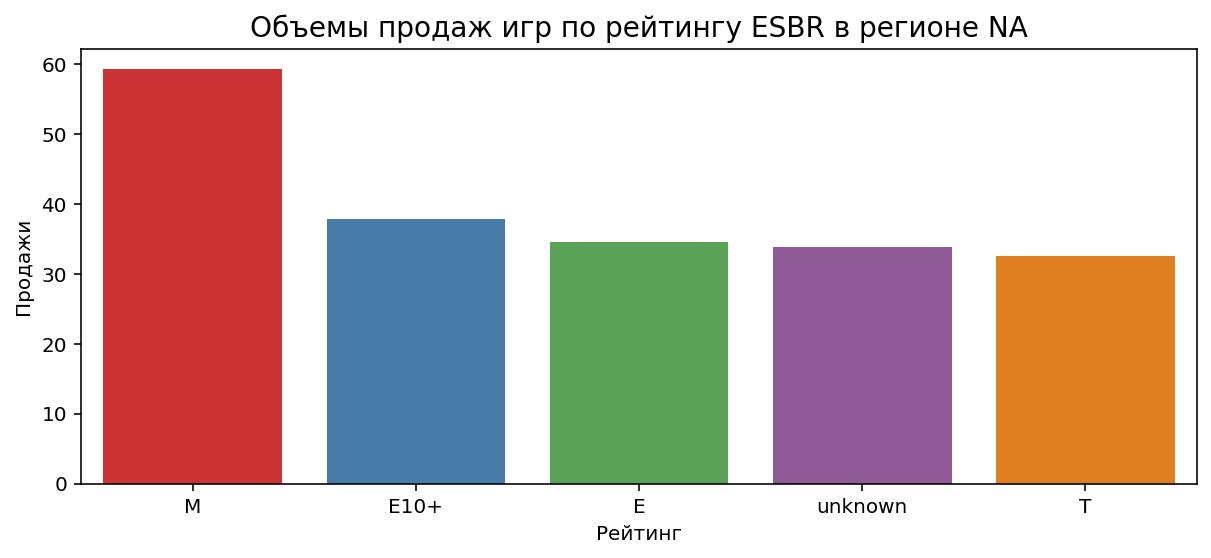

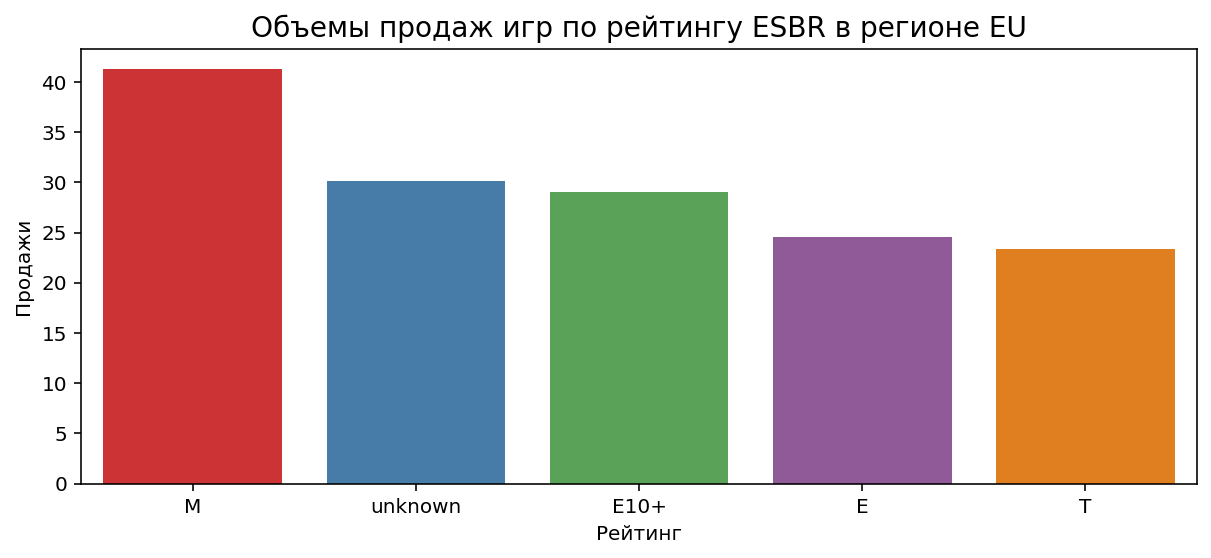

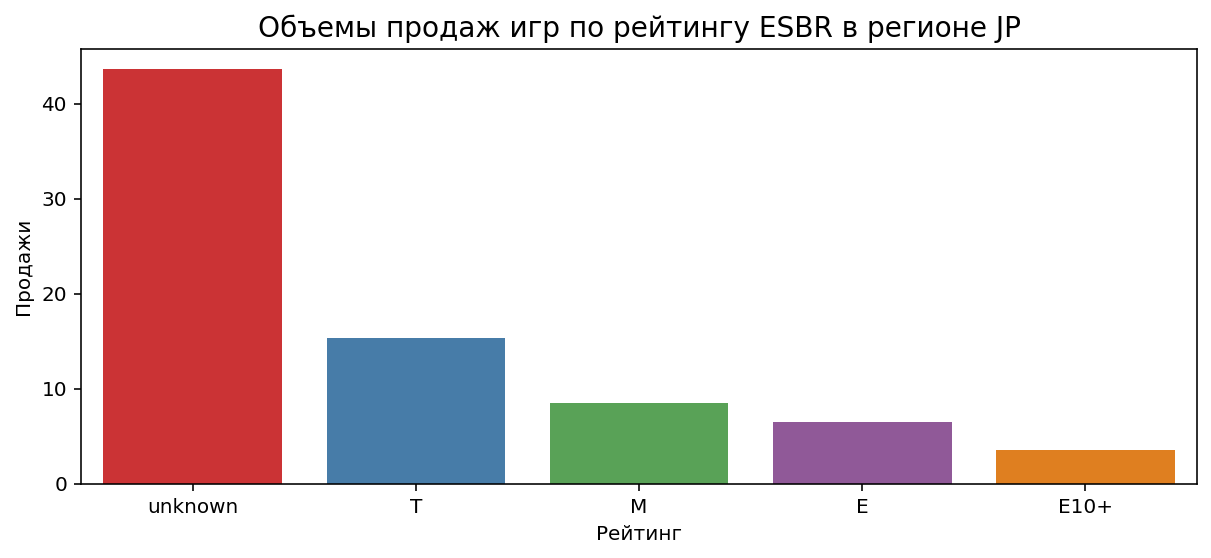

In [119]:
# выведем графики с топ-5 возрастного рейтинга игр для каждого региона

for region in region_list:
    esrb_sales_rating(region)

Вывод: 
- В Северной Америки хорошо продаются игры с рейтингом M, также в топ-3 входят детские игры (E, E10+)
- В Европе также на первом месте игры рейтинга M, но второе место занимает unknown – игры с неопределенным рейтингом. Вероятно, это связано с тем, что ESBR – система рейтингов, используемая в основном в США и Канаде. Для Европы была бы актуальна оценка по системе PEGI
- В Японии на первом месте unknown по той же причине – в этой стране используется система рейтингов CERO

## 5. Проверка гипотез

Для проверки этой гипотезы соберем новый датафрейм, который будет включать в себя все активно продаваемые платформы за последние 5 лет, без фильтра по топ-5 популярных, но с очисткой от выбросов:

In [120]:
# создадим фильтр по межквартильному размаху
Q1_5y = df_5y['total_sales'].quantile(0.25)
Q3_5y = df_5y['total_sales'].quantile(0.75)
IQR_5y = Q3_5y - Q1_5y

# создадим новый датафрейм с очищенными от выбросов данными за 5 лет
df_5y_filtered = df_5y.query('(@Q1_5y - 1.5 * @IQR_5y) \
    <= total_sales <= (@Q3_5y + 1.5 * @IQR_5y)')

**Гипотеза 1: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**


- $H_0$: средние пользовательские рейтинги платформ XOne и PC равны
- $H_1$: средние пользовательские рейтинги платформ XOne и PC различаются

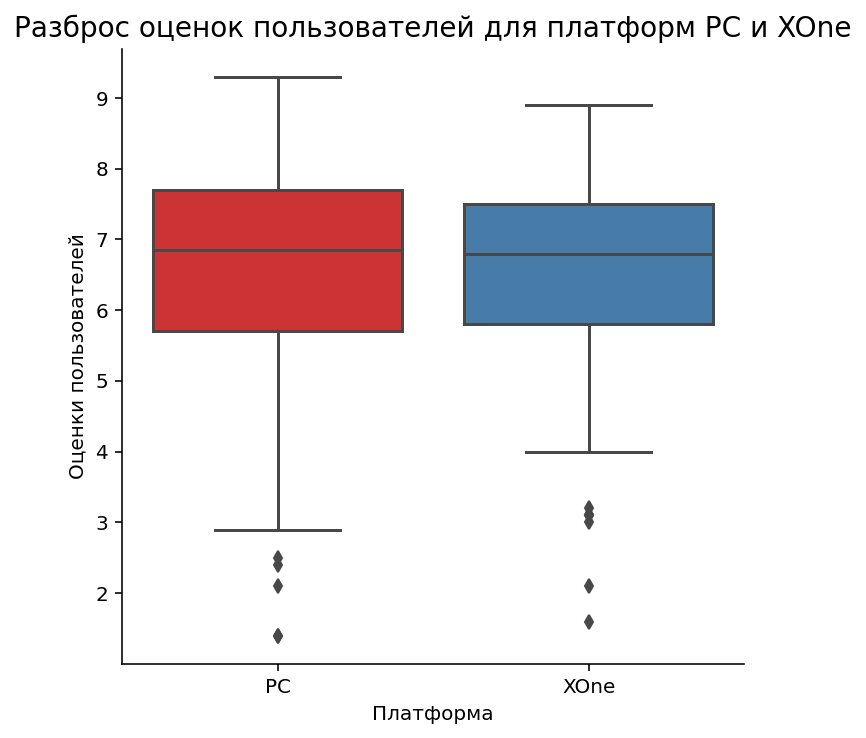

In [121]:
# визуализируем выборки по нужным платформам и оценкам пользователей

pc_xone_user_score = df_5y_filtered.query('platform == "XOne" or platform == "PC"')

sns.catplot(x='platform', y='user_score', \
            kind='box', data=pc_xone_user_score, orient='v')
plt.title('Разброс оценок пользователей для платформ PC и XOne', fontsize=14)
plt.xlabel('Платформа')
plt.ylabel('Оценки пользователей')
plt.show();

In [122]:
# посчитаем медиану, стандартное отклонение и дисперсию по нужным платформам

pc_xone_user_score \
    .groupby(['platform'], as_index=False) \
    .agg({'user_score' : [np.median, np.var, np.std]}) \
    .round(2)

platform user_score            
               median   var   std
0       PC       6.85  2.67  1.63
1     XOne       6.80  2.06  1.43

In [123]:
# расчитаем p-value и проверим нулевую гипотезу

xone_user_score = pc_xone_user_score.dropna() \
    .query('platform == "XOne"')['user_score']

pc_user_score = pc_xone_user_score.dropna() \
    .query('platform == "PC"')['user_score']

alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    xone_user_score, pc_user_score, 
    equal_var=False) # используется критерий Уэлтча, так как дисперсии выборок различаются

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8176149309370433
Не получилось отвергнуть нулевую гипотезу


**Вывод по гипотезе 1:**

Построив группировку и визуализировав данные, **не получилось отвергнуть нулевую гипотезу о равенстве показателей**.

Средняя оценка пользователей для платформ XOne и РС **РАВНА**.

В среднем, пользователи платформы PC оценивают игры так же, как пользователи платформы XOne.

**Гипотеза 2: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные**


- $H_0$: средние пользовательские рейтинги жанров Action и Sports равны
- $H_1$: средние пользовательские рейтинги жанров Action и Sports различаются

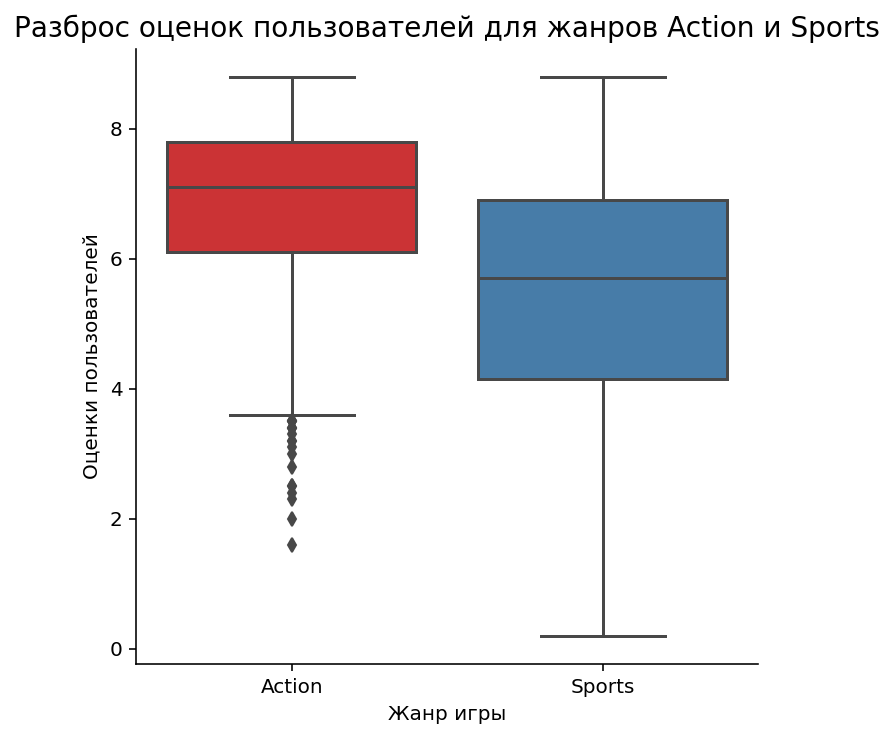

In [124]:
# визуализируем выборки по нужным жанрам и оценкам пользователей

action_sports_user_score = df_5y_filtered.query('genre == "Action" or genre == "Sports"')

sns.catplot(x='genre', y='user_score', kind='box', \
            data=action_sports_user_score, orient='v')
plt.title('Разброс оценок пользователей для жанров Action и Sports', fontsize=14)
plt.xlabel('Жанр игры')
plt.ylabel('Оценки пользователей')
plt.show();

In [125]:
# посчитаем медиану, стандартное отклонение и дисперсию по нужным жанрам

action_sports_user_score \
    .groupby(['genre'], as_index=False) \
    .agg({'user_score' : [np.median, np.var, np.std]}) \
    .round(2)

genre user_score            
              median   var   std
0  Action        7.1  1.95  1.40
1  Sports        5.7  3.48  1.86

In [126]:
# расчитаем p-value и проверим нулевую гипотезу

action_user_score = action_sports_user_score.dropna() \
    .query('genre == "Action"')['user_score']
sports_user_score = action_sports_user_score.dropna() \
    .query('genre == "Sports"')['user_score']

alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    action_user_score, sports_user_score, 
    equal_var=False) # используется критерий Уэлтча, так как дисперсии выборок различаются
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.4610624919853594e-09
Отвергаем нулевую гипотезу


**Вывод по гипотезе 2:**

Построив группировку и визуализировав данные, **отвергаем нулевую гипотезу о равенстве показателей.**

Средняя оценка пользователей для жанров Action и Sports **ОТЛИЧАЕТСЯ**.

В среднем, пользователи оценивают игры жанра Action намного выше, чем игры жанра Sports.

## 6. Общий вывод

Мы проанализировали исторические данные о продажах компьютерных игр, оценки пользователей и экспертов, жанры и платформы, в результате чего выявили определяющие успешность игры закономерности. 


Теперь мы можем спрогнозировать потенциально популярный продукт и спланировать рекламные кампании на 2017 год для компании, которая продает игры по всему миру.



**Общая информация**: в датасете имеются данные за 36 лет, но для планирования продаж мы взяли период в 5 последних лет, в течение которых игры и платформы остаются актуальными

**Лидеры продаж**: пятерка лидеров по суммарным продажам в порядке убывания объемов – PS4, PS3, X360, 3DS, XOne. Четыре из пяти платформ – это стационарные игровые приставки, и одна – мобильная (портативная).

**Жизненные циклы платформ**: 
- Популярные в более раннем приоде PS3 и X360 начали одновременное падение в 2013 и сошли на минимум к 2016. Можно сказать, что это уже не актуальные платформы, не рекомендуются как источник продаж.
- Портативная игровая платформа 3DS занимает 4 место в ТОП-5, но с 2013 начинает терять объемы продаж. Вероятно, это связано с появлением конкурентов – смартфонов, которые становятся с каждым годом всё мощнее и могут посоревноваться в производительности и удобстве. Игры на эту платформу всё ещё могут быть актуальны, но не станут крупным источником объемов продаж. Учитывая медиану жизненного цикла, в ближайшее время есть риск, что платформа выйдет из оборота
- В 2013 году появились 2 новые платформы – PS4 и XOne. Судя по графику, сейчас они являются лидерами продаж. Учитывая медианный срок жизни платфрмы в 7 лет, игры для этих двух платформ находятся на пике популярности и будут оставаться актуальными еще несколько лет. Можно рекомендовать их как главный источник объемов продаж
- Платформа PC всё ещё остается актуальной, хоть и не входит в ТОП-5 за последние 5 лет. Возможно, низкие продажи связаны с распространенным "пиратством" игр на ПК, что снижает количество легальных покупок. Несмотря на это, ПК стоит на первом месте в топе платформ-долгожителей и может рекомендоваться как дополнительный источник продаж

**Распределение продаж**:
- Самая высокая среди конкурентов медиана у X360, также показатели у этой платформы сильно разбросаны (большой межквартильный размах и широкие границы типичных значений). Предположительно, игры для этой платформы продаются стабильно, без особых всплесков 
- Продажи игр на платформы PS3 и XOne схожи между собой как по медиане, так и по размаху. Похоже, что игры для этих платформ продаются примерно одинаково стабильно
- Самый узкий размах и маленькая медиана у платформы 3DS – в основном продажи для этой платформы вырьируются не сильно и протекают на довольно низких уровнях. Но при этом платформа имеет самый большой разброс по выбросам в верхнем диапазоне. Похоже, что продажи игр на эту платформу нельзя назвать стабильными, но рынок встречает появление новых игр для нее с неким ажиотажем
- У платформы PS4 обнаружены средние показатели по всем параметрам: медиана, максимум, разброс. Большое количество выбросов в верхнем диапазоне может говорить о том, что продажи игр для этой платформы идут "волнами", во время которых можно получить хорошую прибыль

**Связь продаж с оценками пользователей и критиков**: 
- Умеренная, но тем не менее самая сильная из представленных, связь оценок критиков с продажами у платформ PS3, X360 и XOne. Это можно использовать в продвижении, выбирая для рекламы игры с более высоким рейтингом критиков. 
- Продажи игр для платформы 3DS слабо коррелируют что с оценками критиков, что с оценками пользователей.

**Продажи по жанрам**:
- самый популярный игровой жанр для топ-5 платформ за последние 5 лет – Shooter. Рекомендуется как первичный источник больших объемов продаж
- жанры Sports и Racing занимают 2 и 3 места в топе жанров соответственно, доли объема их продаж выглядят пригодными для получения прибыли
- платформа XOne – лидер по количеству медианных продаж самого популярного жанра Shooter с большим отрывом от конкурентов, на 2 месте PS3. Так как многие популярные игры портируются на более новые платформы, стоит ожидать, что продажи данного жанра на обновленной платформе PS4 будут тоже высокими
- самый непопулярный жанр для той же выборки – Adventure. Медианные продажи игр для разных платформ не сильно отличаются, однако первое место занимает X360. Не рекомендуется как источник активных продаж


**Популярные платформы по регионам**:
- В Северной Америке самой популярной платформой является Xbox: на первом месте по объемам продаж X360. Так как уже вышла новая версия приставки данной серии, XOne, этот регион представляется наиболее выгодным для продажи игр на новую версию платформы. Сейчас продажи игр на XOne по этому региону занимают третье место и имеют все шансы через пару лет выйти на первое. Также большую долю занимают и продажи конкурентной платформы Playstation, тоже потенциально пригодные для продаж. Рекомендуется для продвижения обеих конкурирующих платформ в равной мере
- В Европе популярна платформа Playstation: PS3 занимает первое, а обновленная PS4 – уже второе место, поэтому рекомендуется в первую очередь для наращивания объемов продаж. Доля Xbox тоже большая, можно рекомендовать для продвижения
- В Японии популярна 3DS – мобильная платформа, которая находится на последнем месте в других странах. На рынке Японии, можно рекомендовать продажи игр под эту платформу. На втором месте по популярности приставки бренда Playstation – суммарно объемы продаж обеих версий можно приравнять к объемам лидера, рекомендовано к продвижению. Почти нет продаж игр на платформу Xbox – она не пользуется популярностью и не рекомендована для продвижения в данном регионе

**Жанры по регионам**: 
- Во всех регионах не первом месте по продажам жанр Action – отличный вариант для получения стабильных прибылей от продаж
- Практически идентичная картина популярных жанров для Северной Америки и Европы: спортивные игры (Sports), шутеры (Shooter) и ролевые игры (Role-Playing) занимают 2, 3 и 4 места топа продаж соответственно
- В Японии основную массу продаж занимают Action и Role-Playing, другие жанры сильно отстают по объемам
- Особенности регионов: в Северной Америке в топ-5 входит жанр Misc, в Европе интересуются жанром Racing, а Японию отличает любовь к жанру Fighting

**Возрастные рейтинги по регионам**: 
- В Северной Америки хорошо продаются игры с рейтингом M, также в топ-3 входят детские игры (E, E10+)
- В Европе также на первом месте игры рейтинга M, но второе место занимает unknown – игры с неопределенным рейтингом. Вероятно, это связано с тем, что ESBR – система рейтингов, используемая в основном в США и Канаде. Для Европы была бы актуальна оценка по системе PEGI
- В Японии на первом месте unknown по той же причине – в этой стране используется система рейтингов CERO

**Проверка гипотез**:
1. Средняя оценка пользователей для платформ XOne и РС РАВНА.

2. Средняя оценка пользователей для жанров Action и Sports ОТЛИЧАЕТСЯ. В среднем, пользователи оценивают игры жанра Action намного выше, чем игры жанра Sports.










**Факторы успешности и рекомендации по рекламной кампании**
1. **Платформа** – большую долю рынка занимают приставки двух конкурирующих платформ: Playstation и Xbox. Всё ещё продолжаются продажи игр на приставки предыдущего поколения, но для успеха рекламной кампании стоит сделать упор на самые новые версии – PS4 и XOne
2. **Жанр** – стоит обратить вимание на игры жанра Action для развития продаж во всех регионах. Есть особенности по предпочитаемым жанрам для каждого региона: например, игры жанра RPG лучше всего продвигать в Японии
3. **Регион** - каждый регион имеет свои особенности в предпочтениях по жанру, платформе и иигровым рейтингам. Стоит планировать рекламные кампании для каждого региона отдельно, разделяя их по этим особенностям
4. **Оценки критиков** – для платформ, где есть корреляция между оценкой критиков и объемом продаж рекомендуется изображать в рекламных материалах показатель этой оценки (при наличии). Это позволит стимулировать интерес к игре у фанатов платформы
5. **Оценки пользователей** – в изображениях для рекламной кампании для X360 можно использовать оценки пользователей (при наличии), так как у данной платформы есть связь этого показателя с объемами продаж. Это может немного усилить эффект от рекламы
6. **Возрастной рейтинг** – в Северной Америке и Европе проще всего будет продать игры с рейтингом "для взрослых", тогда как в Японии лучше планировать продажи исходя из местного рейтинга (данным по нему в выборке не было)
7. **Распределение продаж** – для некоторых платформ существуют всплески продаж, вероятно, связанные с выходом новых игр. Это можно использовать при планировании РК, усиливая продвижение с выходом долгожданных игр

Комплексное применение полученных при данном анализе рекомендаций поможет спланировать успешную рекламную кампанию.




